In [1]:
#Imports
import numpy as np
import tifffile as tle
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
import os
import time
from keras.layers import *
from keras.models import Model
from keras.callbacks import *
from sklearn.metrics import confusion_matrix
import sklearn
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
from keras.layers.normalization import BatchNormalization
from skimage.filters import roberts, sobel

/home/rithwik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import tifffile as tiff
import os
from keras.utils import to_categorical
from skimage import io

In [3]:
#Uner Architecture
def get_unet():
    inputs = Input((96, 96, 5))
    inputs_2 = Input((96,96,1))
    inputs_3 = Input((96,96,1))


    conv1 = Conv2D(32, 3, activation='elu', padding='same',data_format='channels_last')(inputs)
    conv1 = Conv2D(32, 3, activation='elu', padding='same')(conv1)

    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='elu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='elu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    conv3 = BatchNormalization()(conv3)


    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256,  3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up_1 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up_1, conv4])


    conv6 = Conv2D(256,  3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256,  3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128,  3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2] )
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64,  3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, 3, activation='elu', padding='same')(up9)
    conv9 = Conv2D(32,  3, activation='elu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv11 = Conv2D(64, 3, activation='elu', padding='same')(inputs_3)
    conv12 = Conv2D(64, 3, activation='elu', padding='same')(conv11)


    conv9 = concatenate([conv9,inputs_2,conv12])
    conv9 = BatchNormalization()(conv9)




    conv10 = Conv2D(10, 1,  activation='softmax')(conv9)

    model = Model(input=[inputs,inputs_2,inputs_3], output=conv10)




    return model


In [3]:
#Function to create mapping. Converts the Ground truth to the format accepted by neural nets
def create_mapping(img):
        patch_size = 96
        lst=[]
        d = {0: 0, 2715: 7, 2220: 6, 2830: 8, 1110: 4, 280: 9, 95: 1, 1500: 5, 125: 2, 255: 3}
        
        dict_cnt=0

        

        im = np.copy(img)
        #print (img.shape)
        
        old_size = im.shape[:2] # old_size is in (height, width) format
        
        delta_w = patch_size * (old_size[1]//patch_size) + patch_size  - old_size[1]
        delta_h = patch_size * (old_size[0]//patch_size)+ patch_size - old_size[0]

        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        
        
        res = im[:,:,0].astype(np.float32)*.01 + im[:,:,1].astype(np.float32)*.1 + im[:,:,2].astype(np.float32)*1
        res = np.uint32(res*10)
        
        unique_vals = np.unique(res)
        
        for q in unique_vals:
            #print (q)
            if q in d:
                
                res[res==q] = d[q]
            else:
                
                print ("Not Found!")
     
            
            
        return res


In [4]:
#FUnction to generate the predictions from the image
def generate_whole_mask(img,weights_path):
    #print ("from func",img.shape)
    
    patch_size = 96
    
    model = get_unet()
    
    model.load_weights(weights_path)
    
    im = np.copy(img)
    
    image=im[:,:,:]
    

    loop_1 =  img.shape[1]//patch_size
    loop_2 =  img.shape[0]//patch_size
        
    
    preds_arr = np.zeros((  img.shape[0] , img.shape[1] )) 
    

    

    for h in range(loop_2):
        for w in range(loop_1):


            common_img = im[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size,:]

            common_img = (common_img)/ 4096.0

            p1 = np.expand_dims(common_img[:,:,4],axis=2)
            p2 = np.expand_dims(common_img[:,:,3],axis=2)
            #print (common_img.shape)


            pred = model.predict([np.expand_dims(common_img,axis=0),np.expand_dims(p1,axis=0),np.expand_dims(p2,axis=0)])[0]

            #print (pred.shape)

            pred[:,:,8] = 0

            pred = np.argmax(pred,axis=2)
            
            
            preds_arr[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size] = pred




    return preds_arr
            

In [5]:
#FUnction to convert the outputs of Neural Network to the dataset format
def inverse_map(pred):
    pred = np.uint8(pred)
    pred = pred[..., np.newaxis]
    pred = np.where(pred == [10], [0, 0, 0], pred)
    pred = np.where(pred == [0], [0, 0, 0], pred)
    pred = np.where(pred == [1], [150, 80, 0], pred)
    pred = np.where(pred == [2], [0, 125, 0], pred)
    pred = np.where(pred == [3], [0, 255, 0], pred)
    pred = np.where(pred == [4], [100, 100, 100], pred)
    pred = np.where(pred == [5], [0, 0, 150], pred)
    pred = np.where(pred == [6], [200, 200, 200], pred)
    pred = np.where(pred == [7], [150, 150, 255], pred)
    pred = np.where(pred == [8], [255, 255, 255], pred)
    pred = np.where(pred == [9], [255, 255, 0], pred)
    return pred

Running for Image 1
24 25 38 38


/home/rithwik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


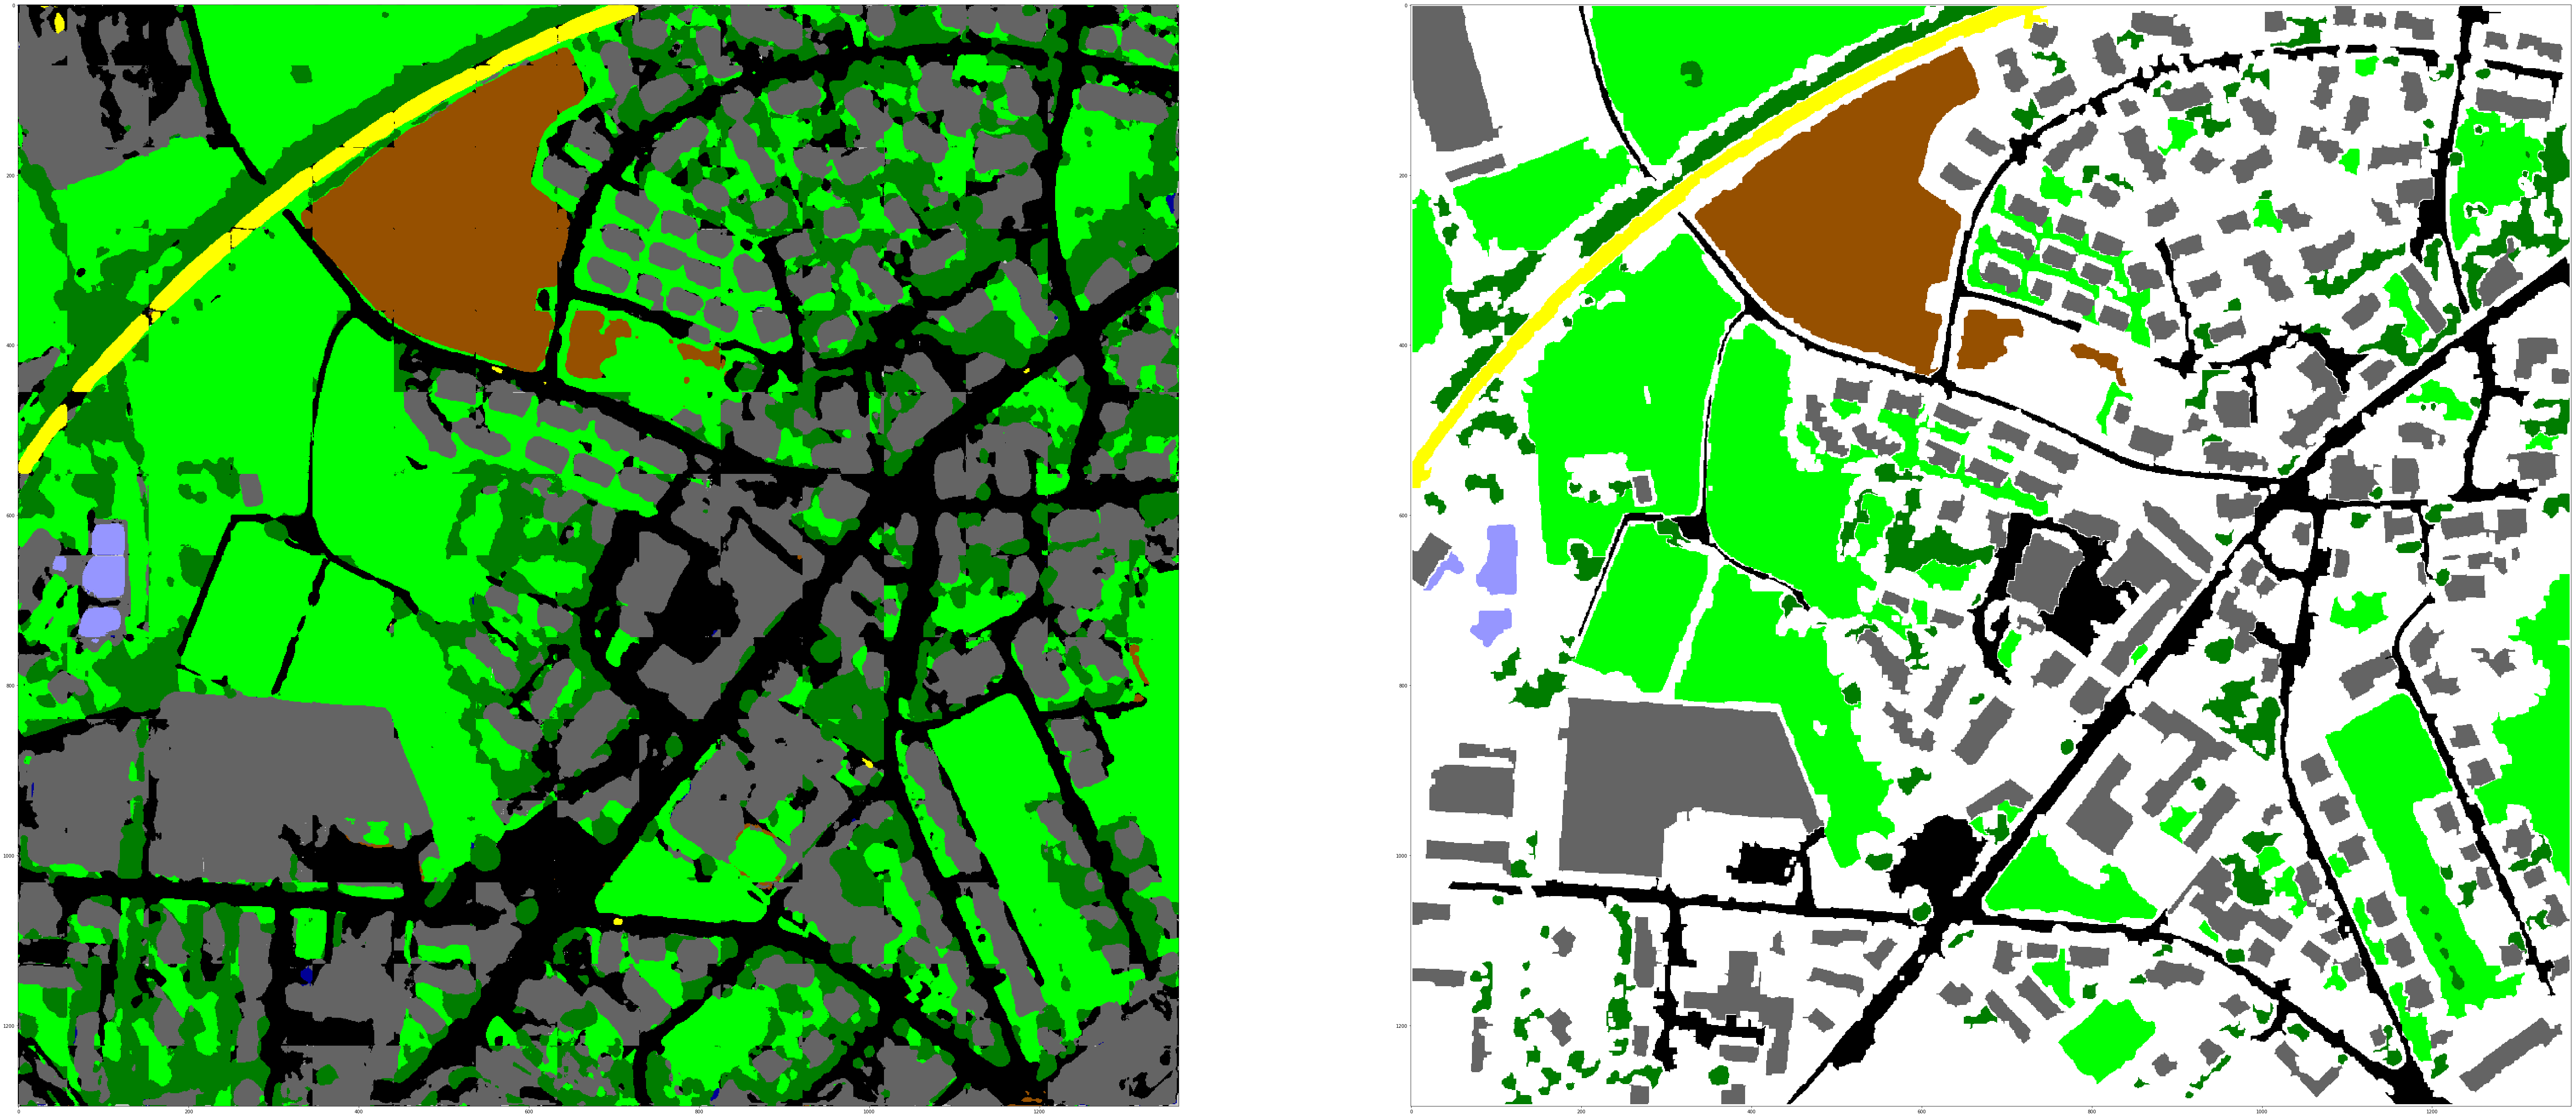

Accuracy is 0.9746157143374379 while leaving Image1
kappa Coef value is 0.9659386825524316
Running for Image 2
17 17 8 9


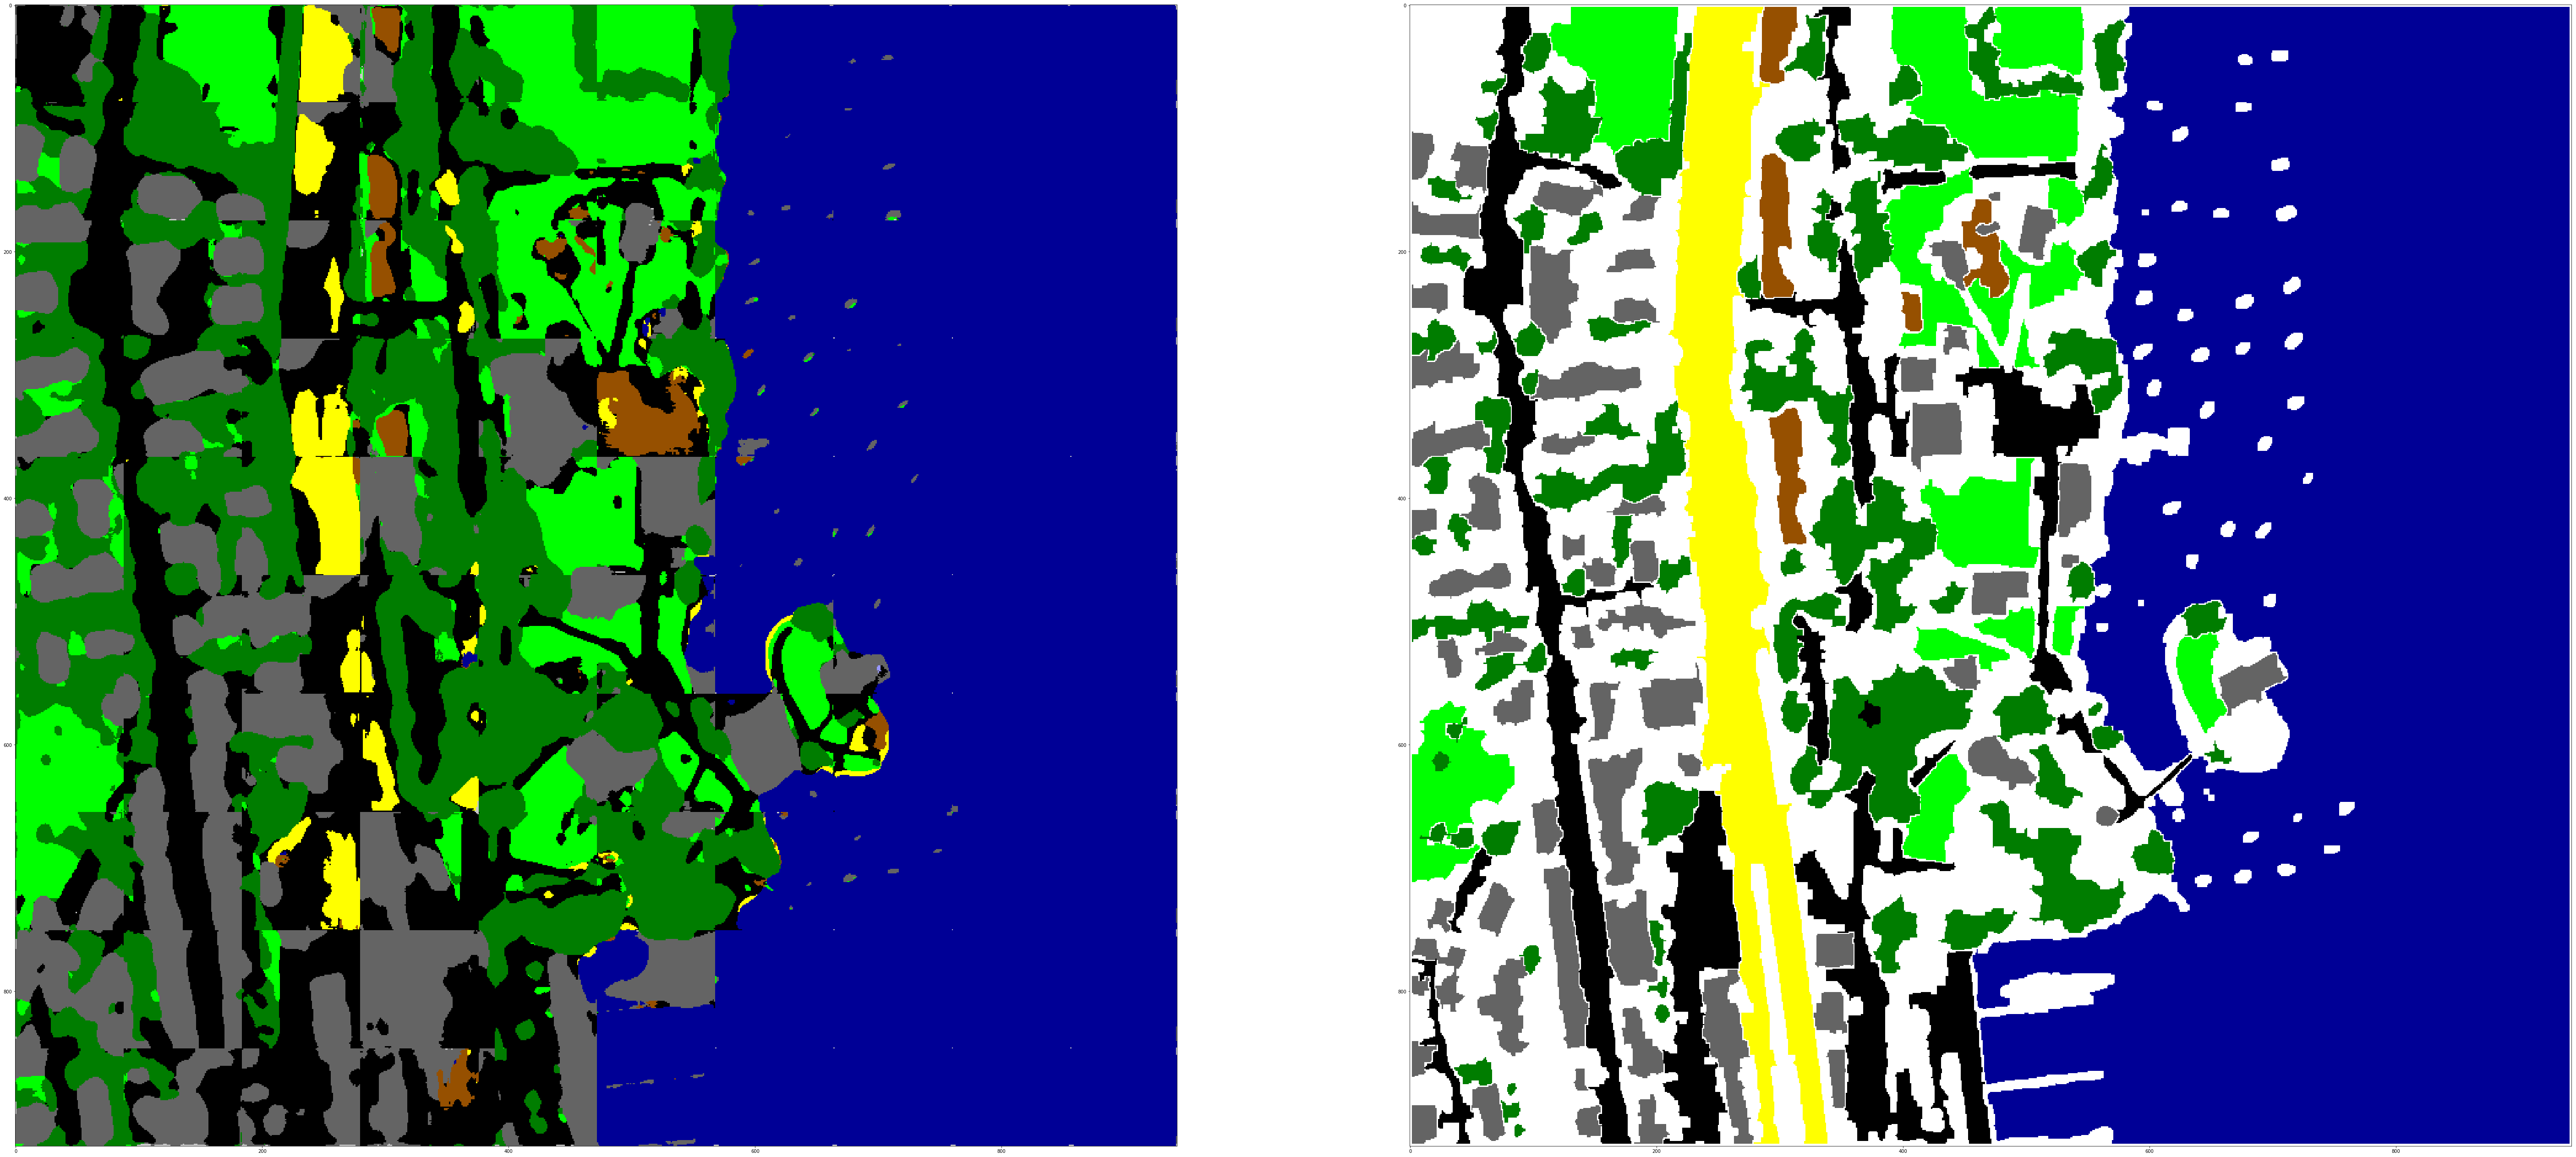

Accuracy is 0.8851553528135766 while leaving Image2
kappa Coef value is 0.8303396214034359
Running for Image 3
22 23 33 33


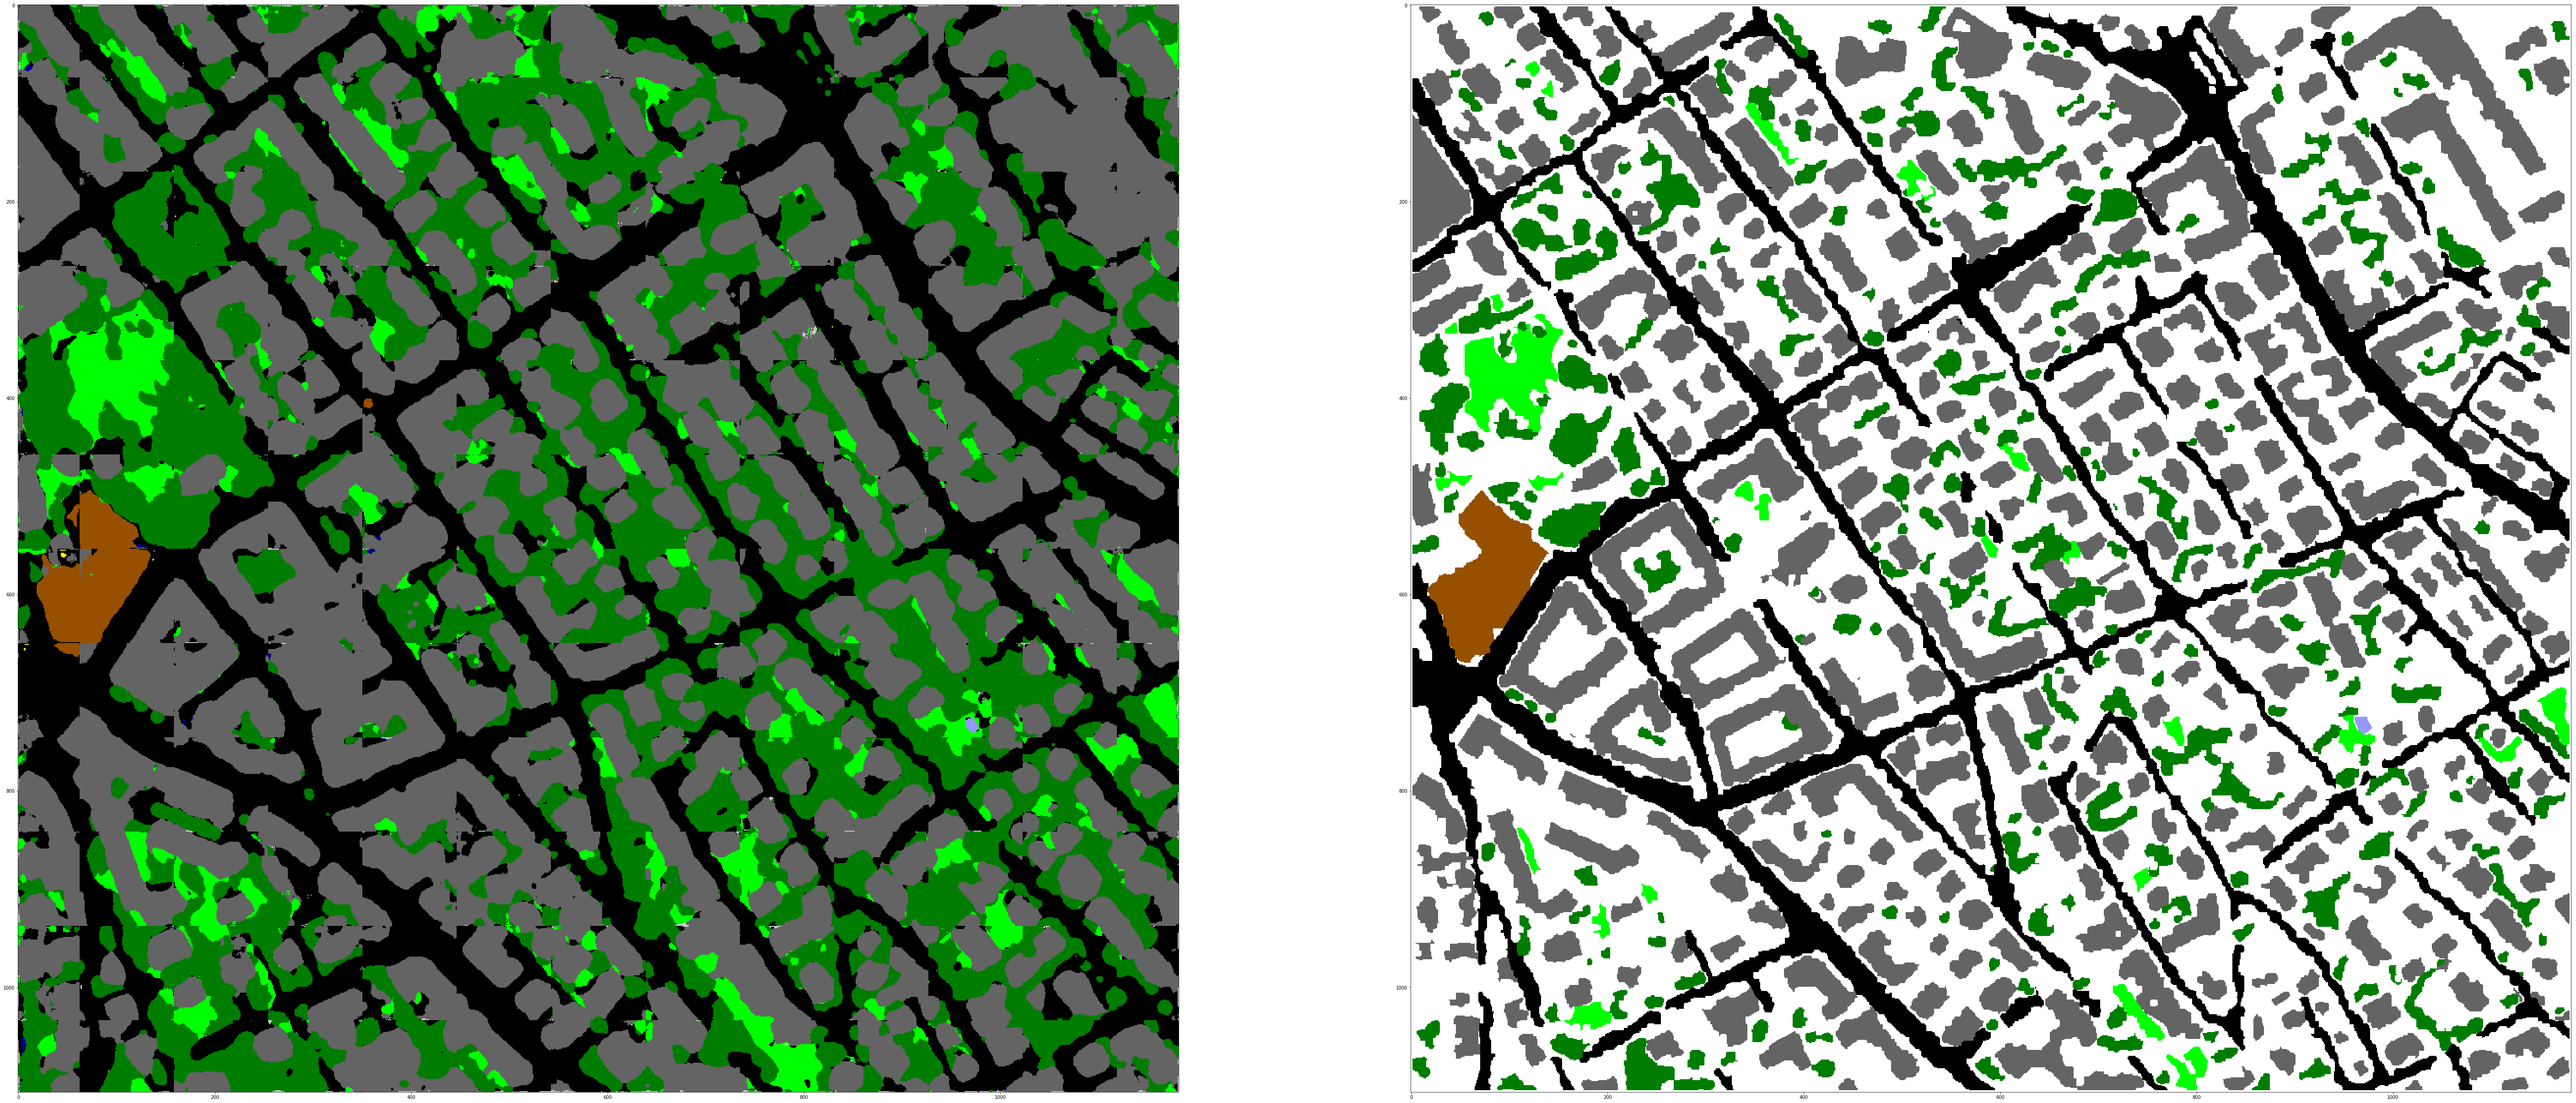

Accuracy is 0.9715674830879492 while leaving Image3
kappa Coef value is 0.9545955911869192
Running for Image 4
44 45 28 28


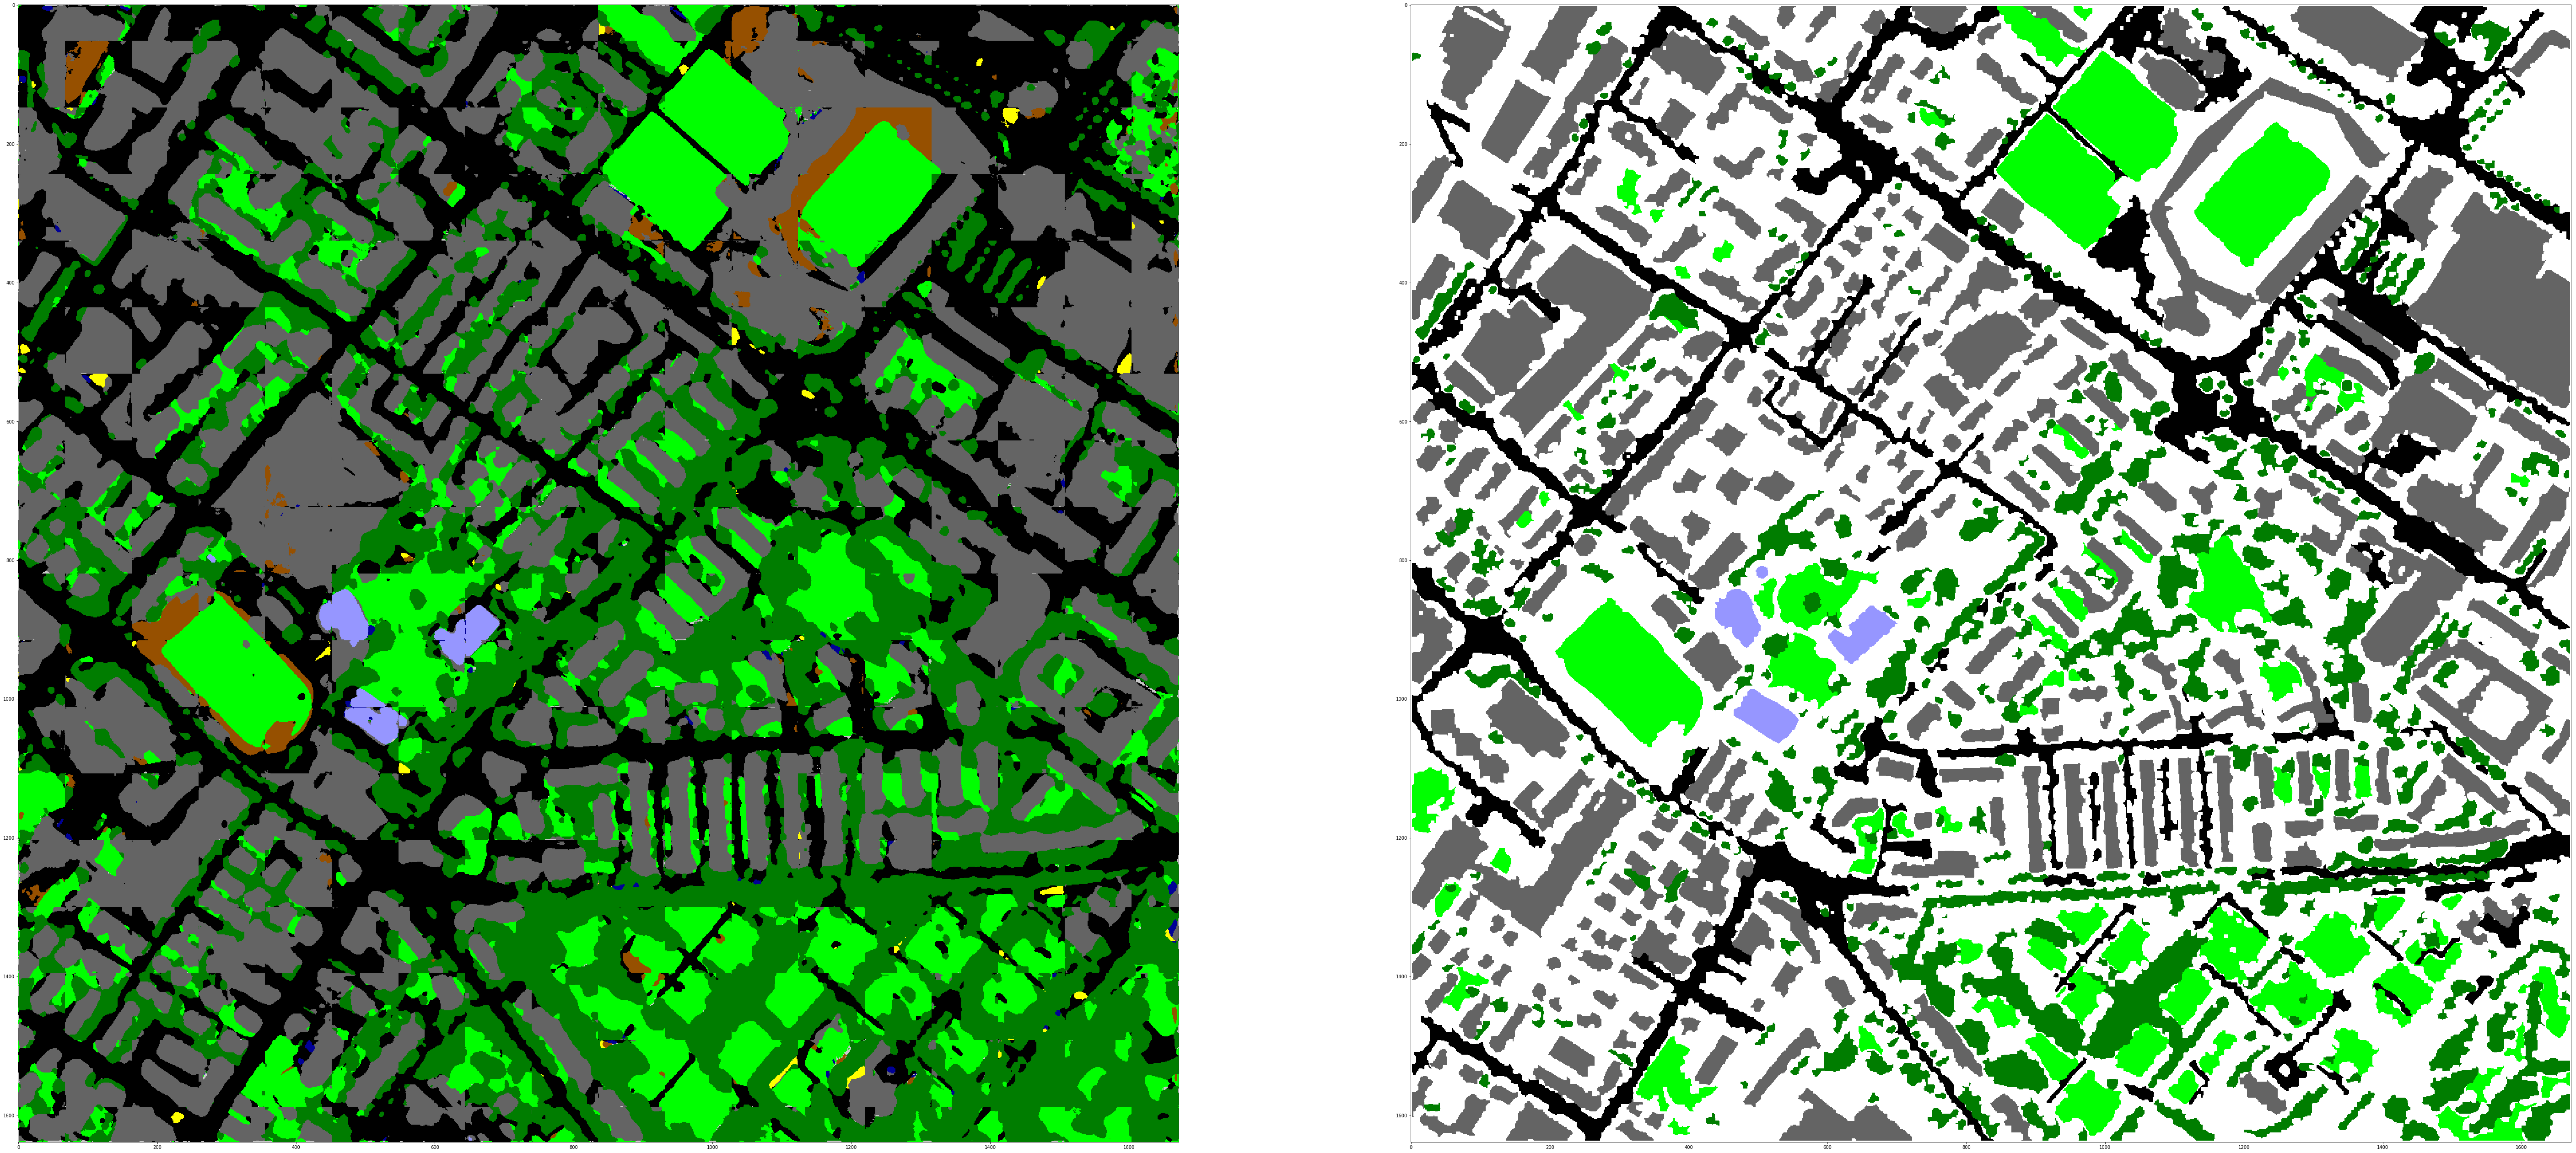

Accuracy is 0.8927153236962391 while leaving Image4
kappa Coef value is 0.8495871969047375
Running for Image 5
1 1 44 45


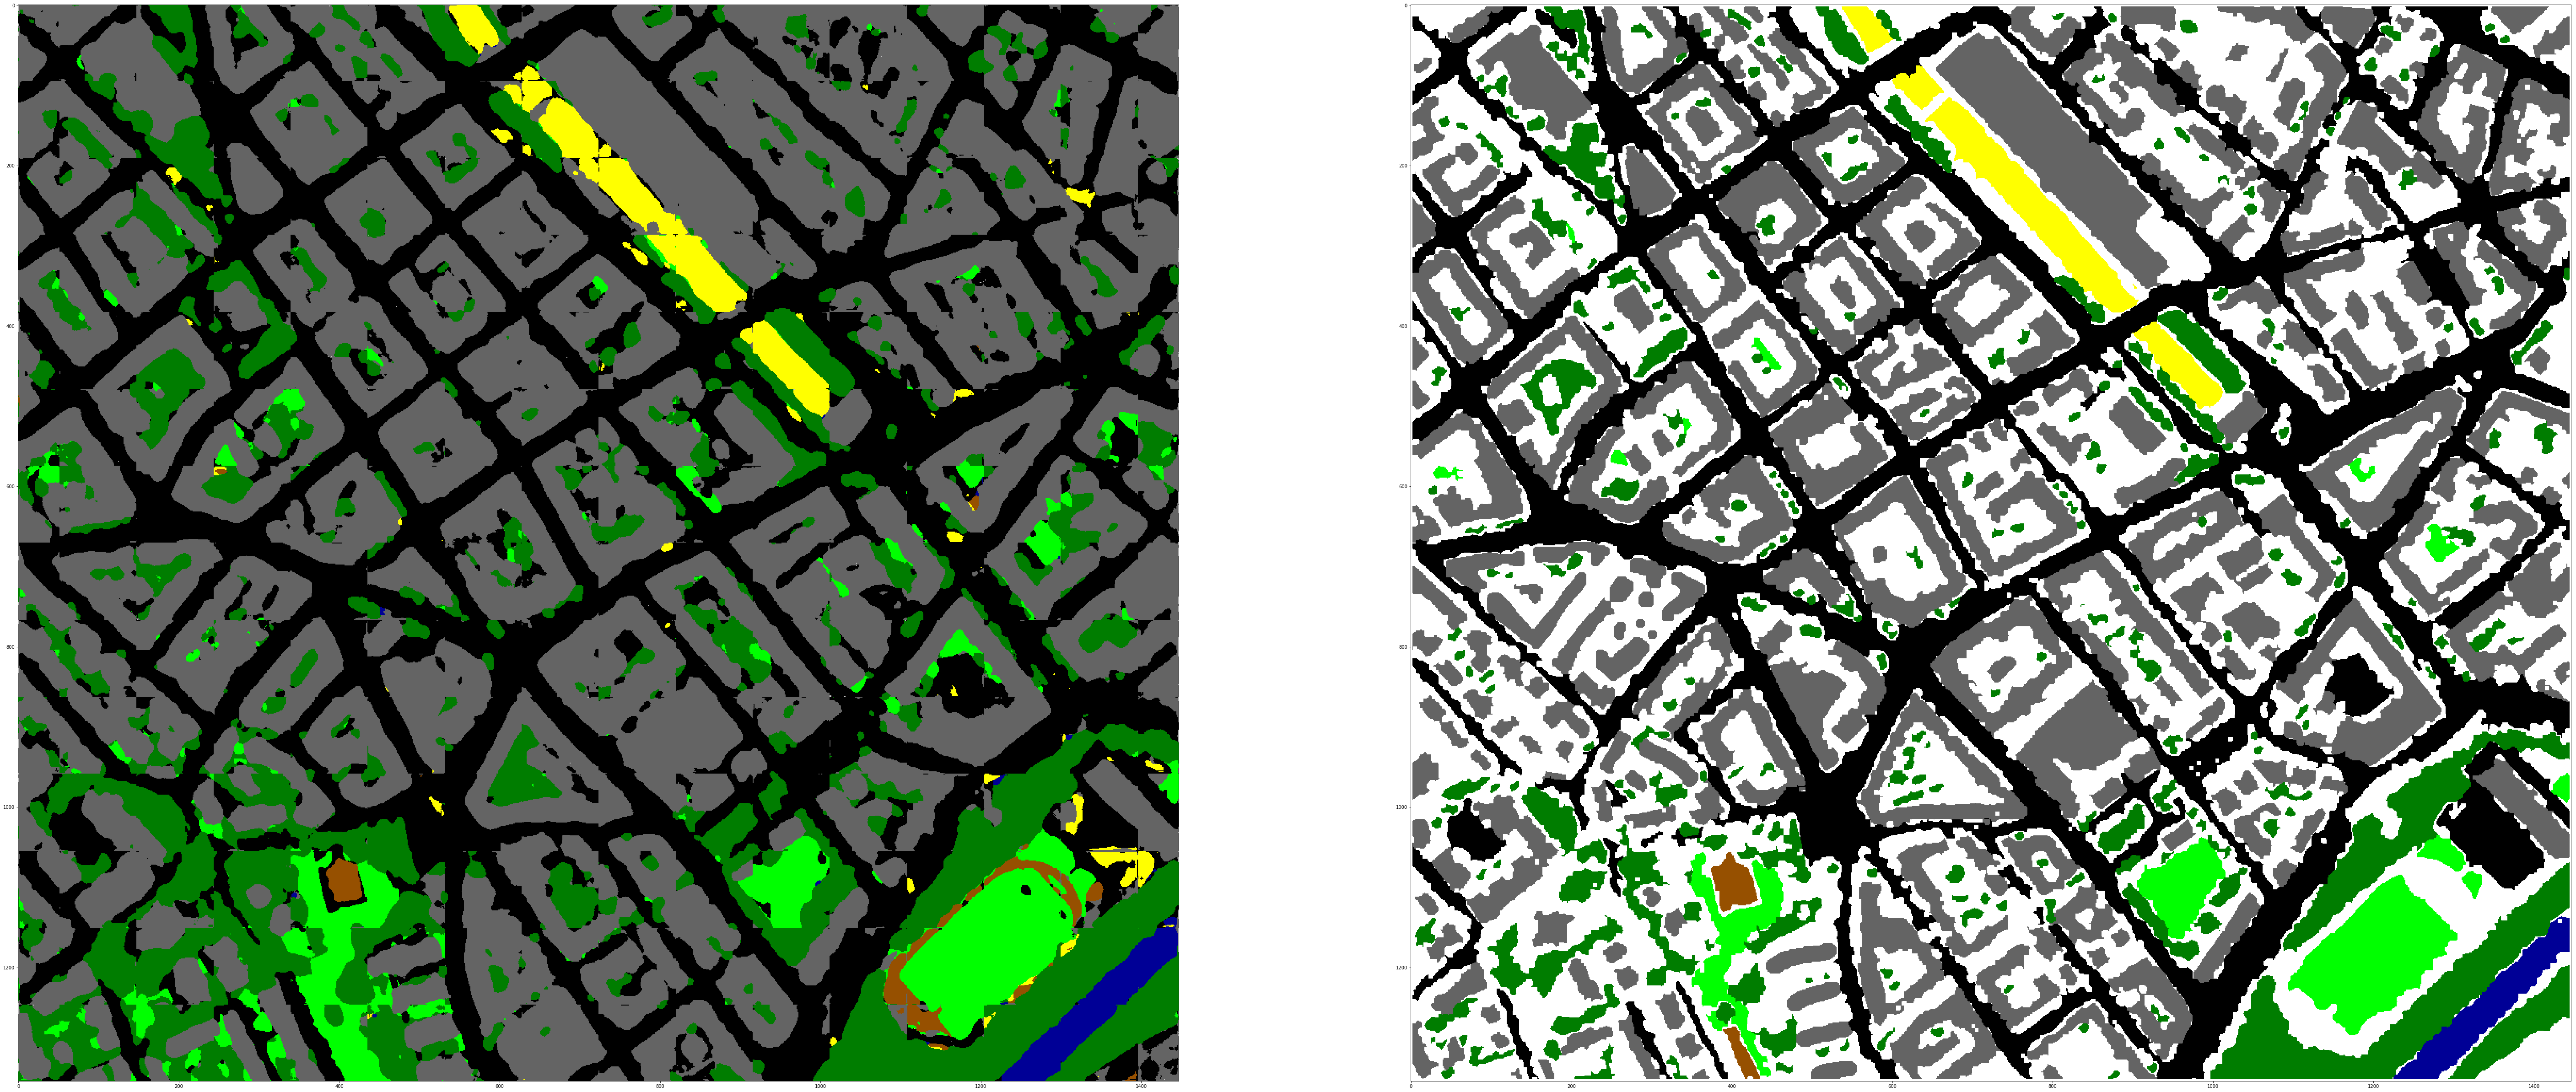

Accuracy is 0.9594417481119959 while leaving Image5
kappa Coef value is 0.9375193056661855
Running for Image 6
39 39 25 25


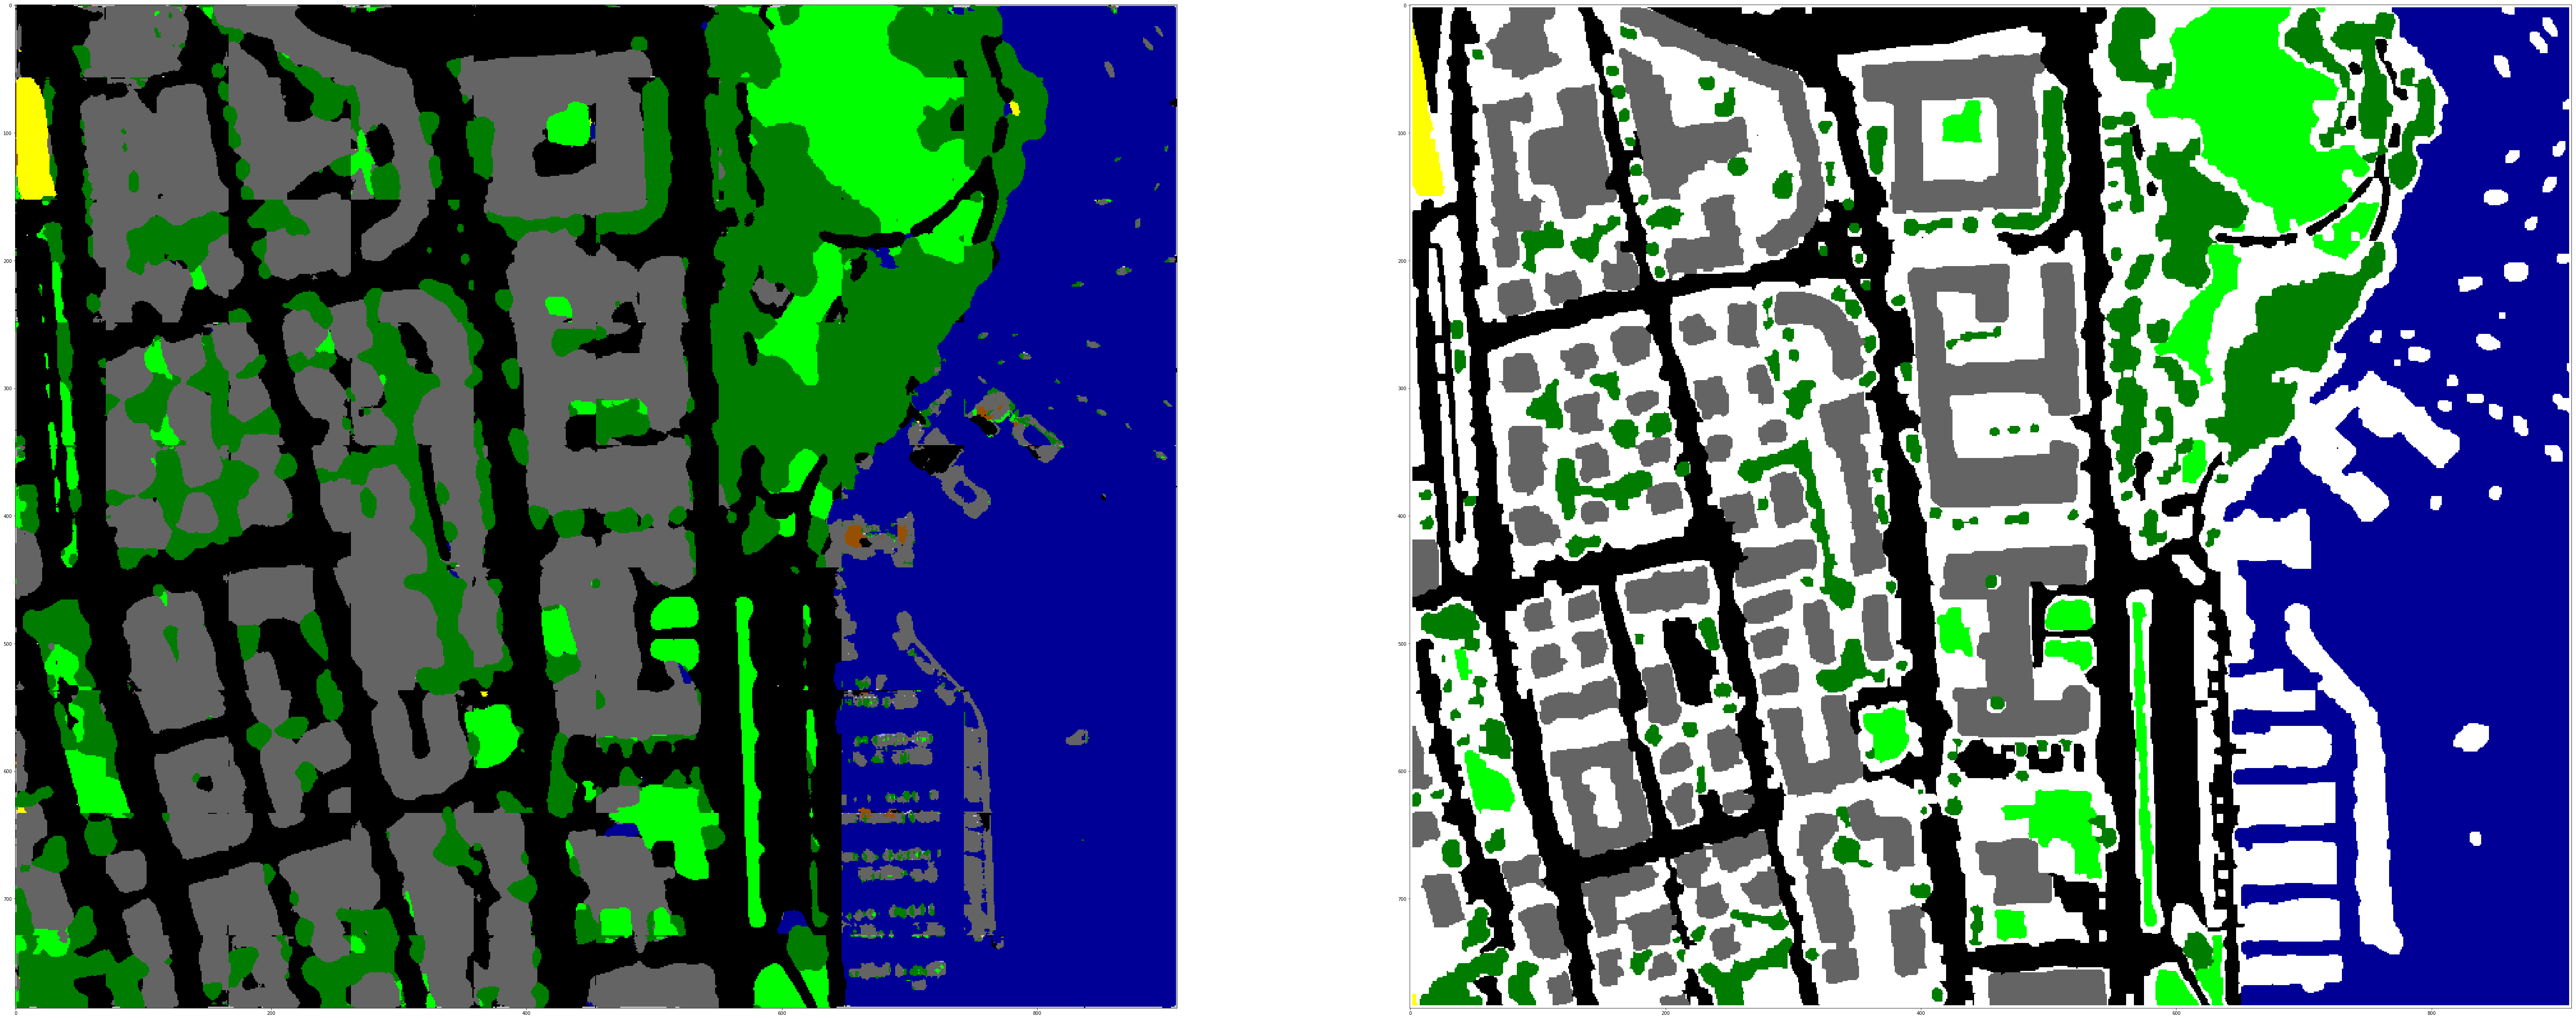

Accuracy is 0.9814980406316706 while leaving Image6
kappa Coef value is 0.9757076644407355
Running for Image 7
1 2 3 3


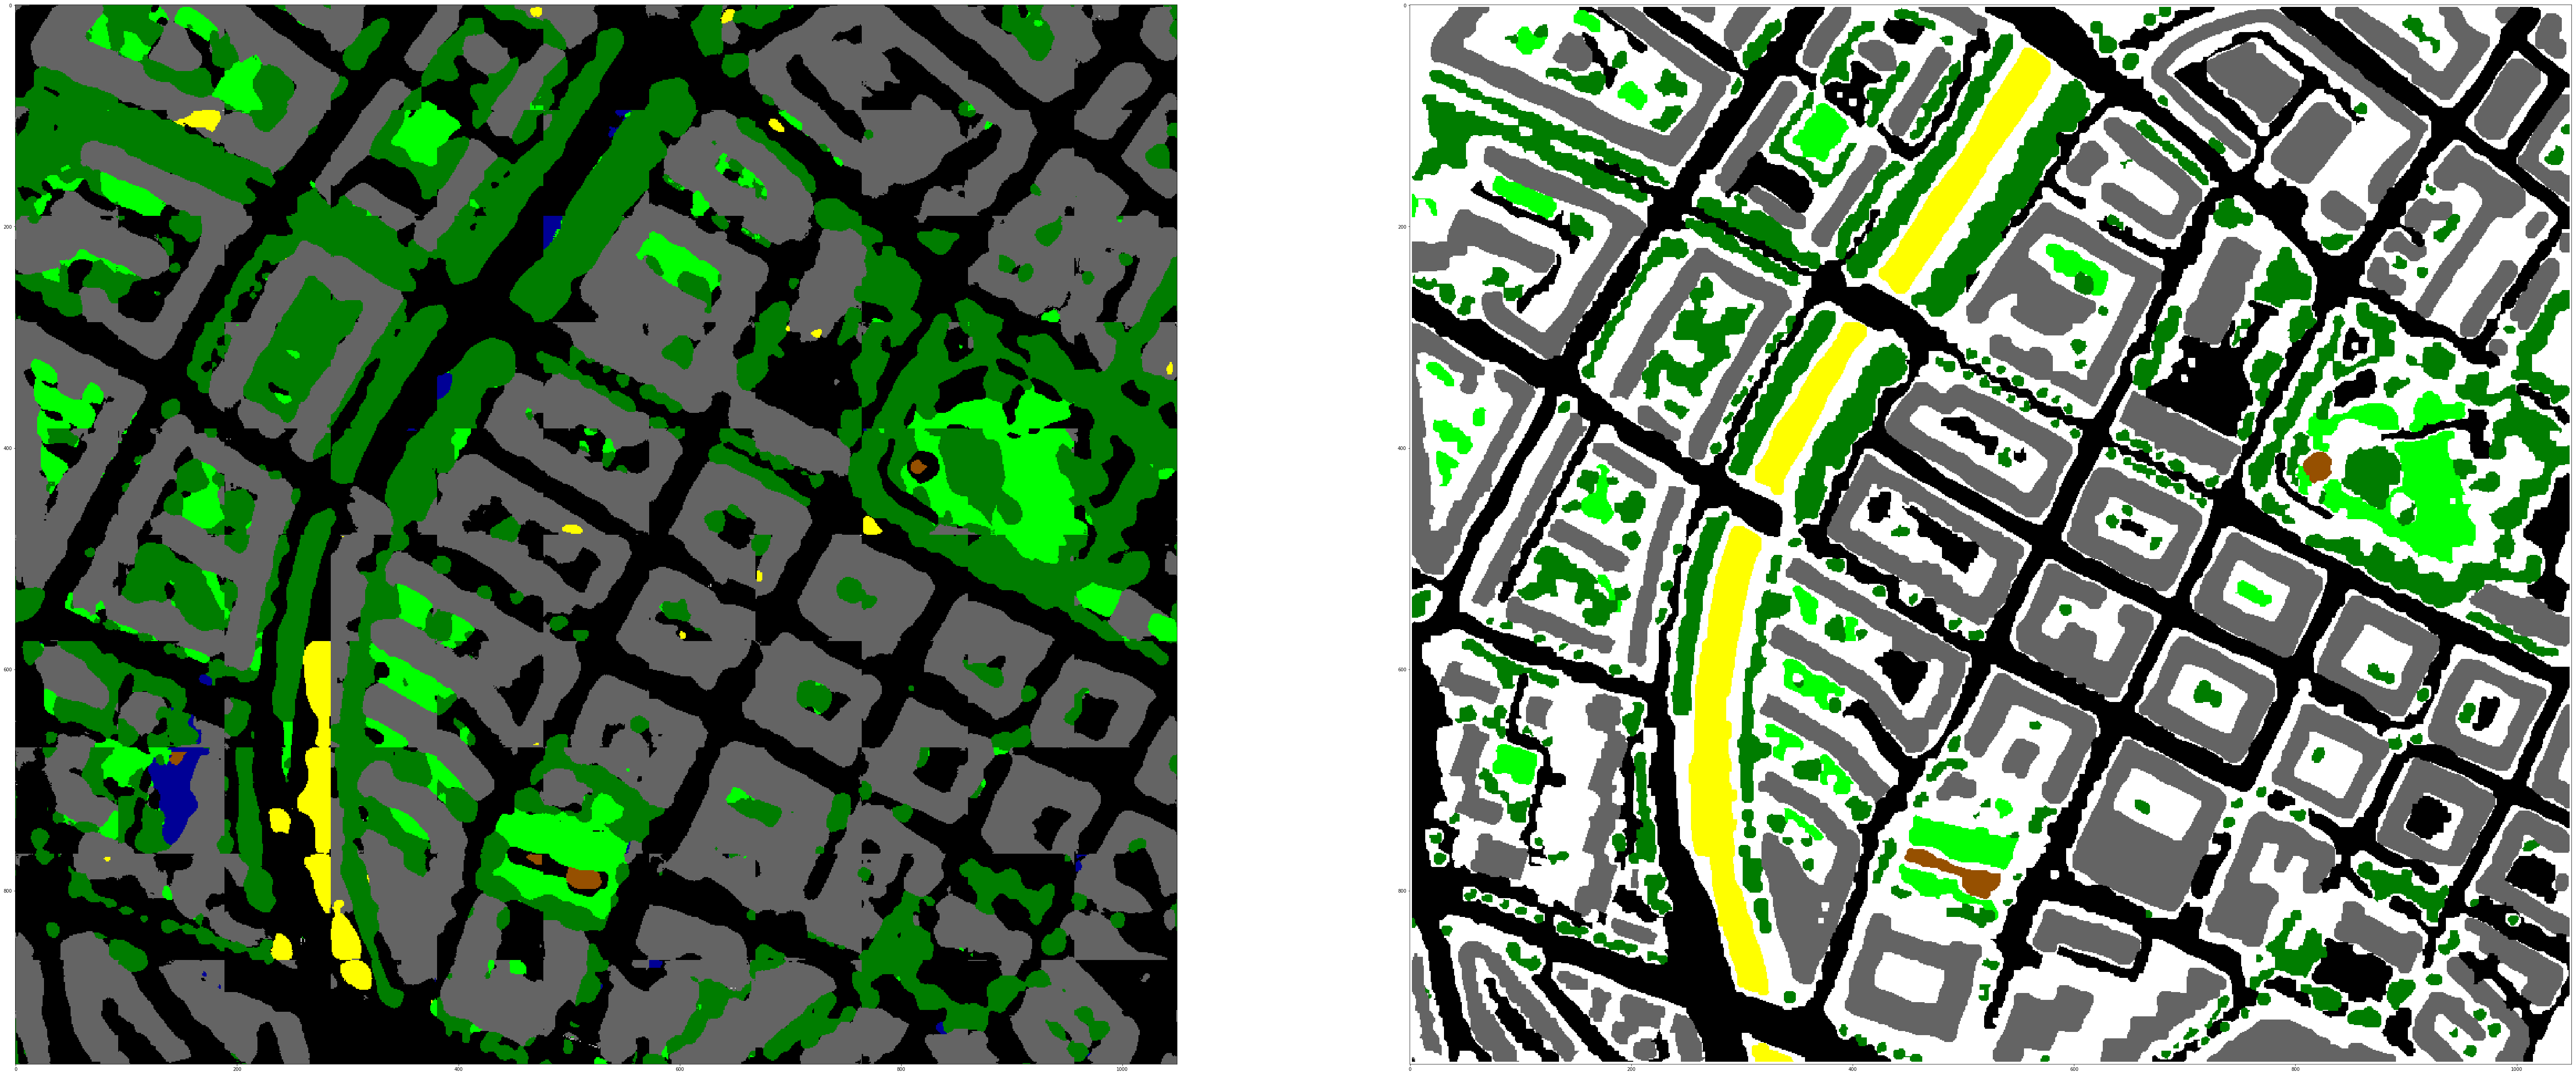

Accuracy is 0.8902131735650136 while leaving Image7
kappa Coef value is 0.8377354837374029
Running for Image 8
3 3 44 44


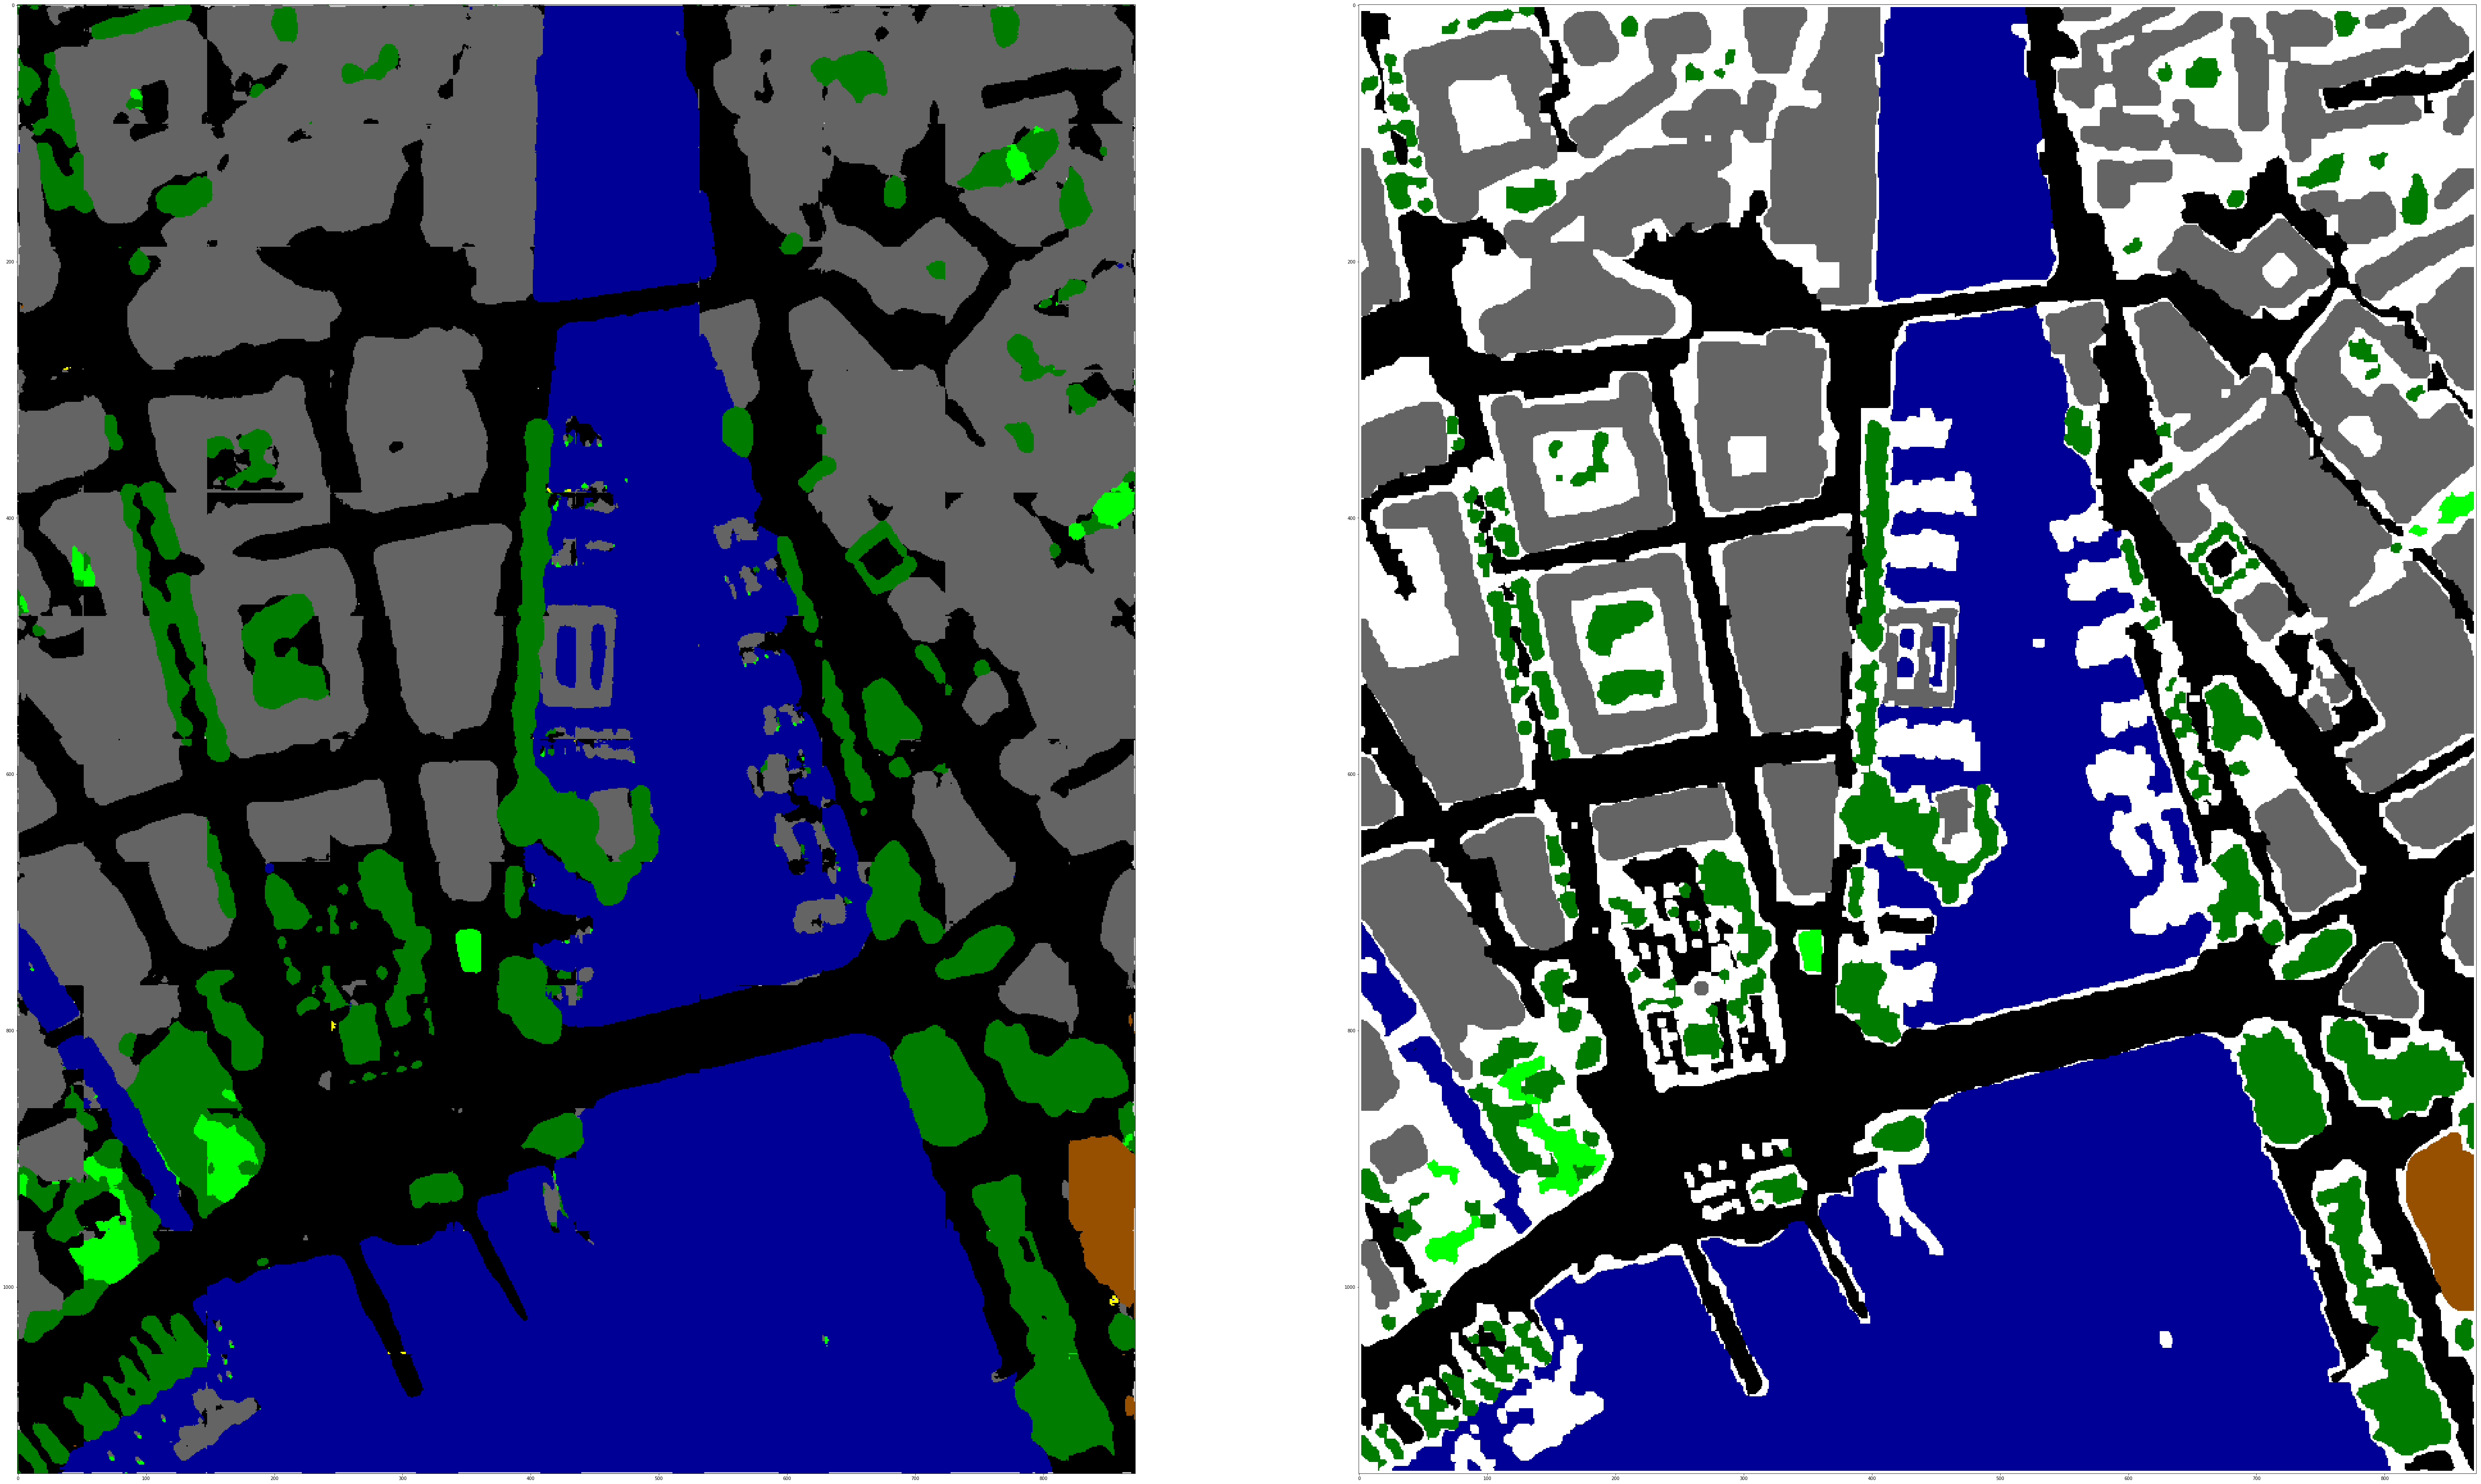

Accuracy is 0.9788464874683648 while leaving Image8
kappa Coef value is 0.9705185608331668
Running for Image 9
10 10 32 32


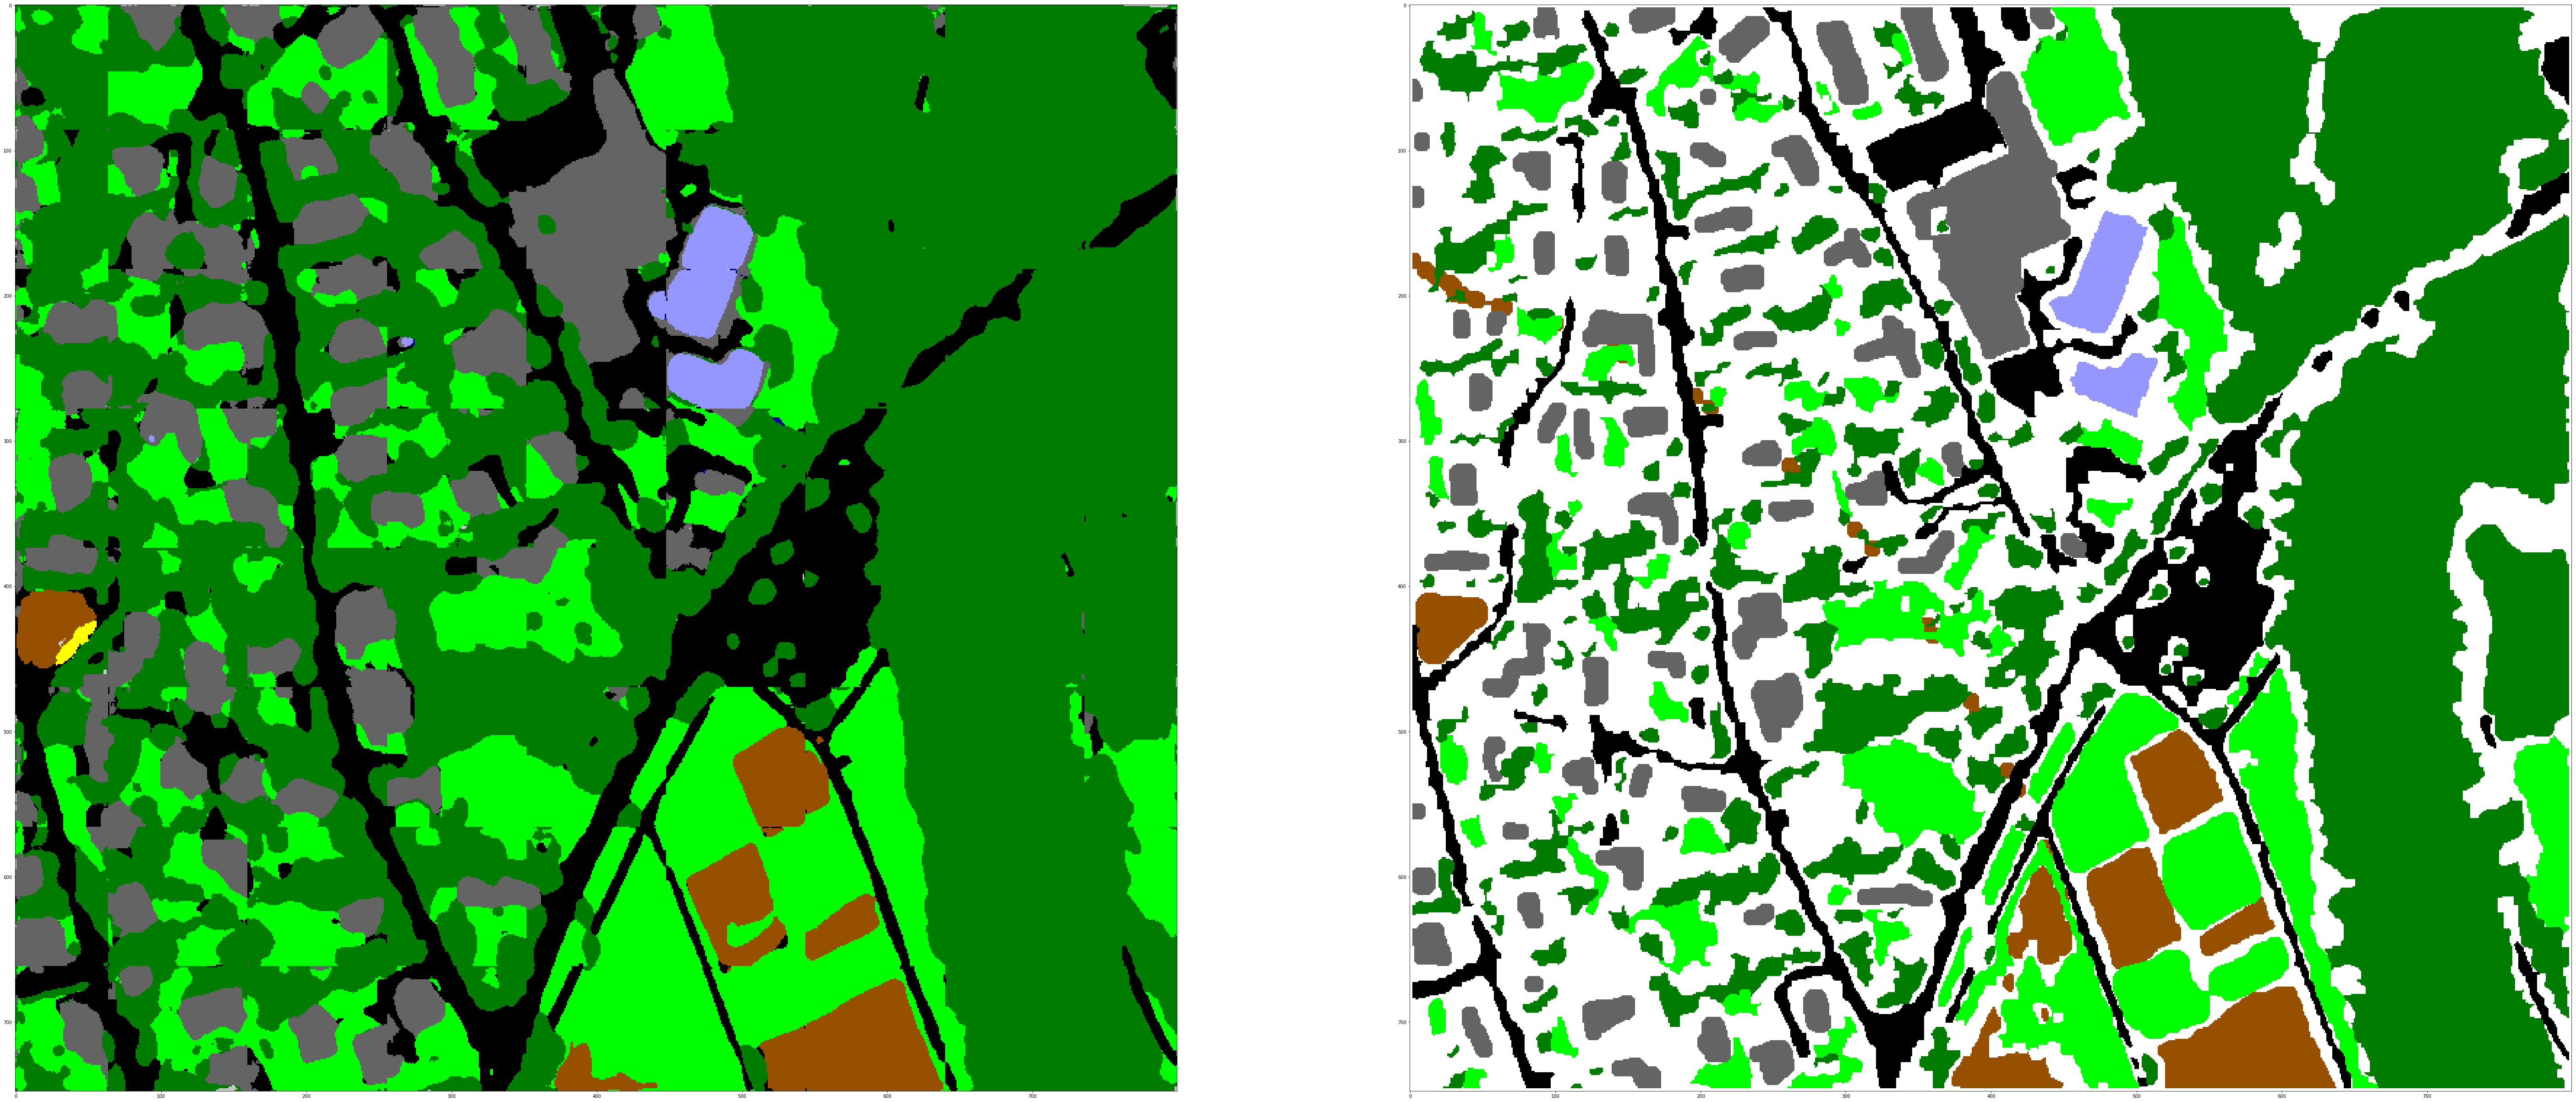

Accuracy is 0.9625038879400193 while leaving Image9
kappa Coef value is 0.9444180704944527
Running for Image 10
43 43 22 23


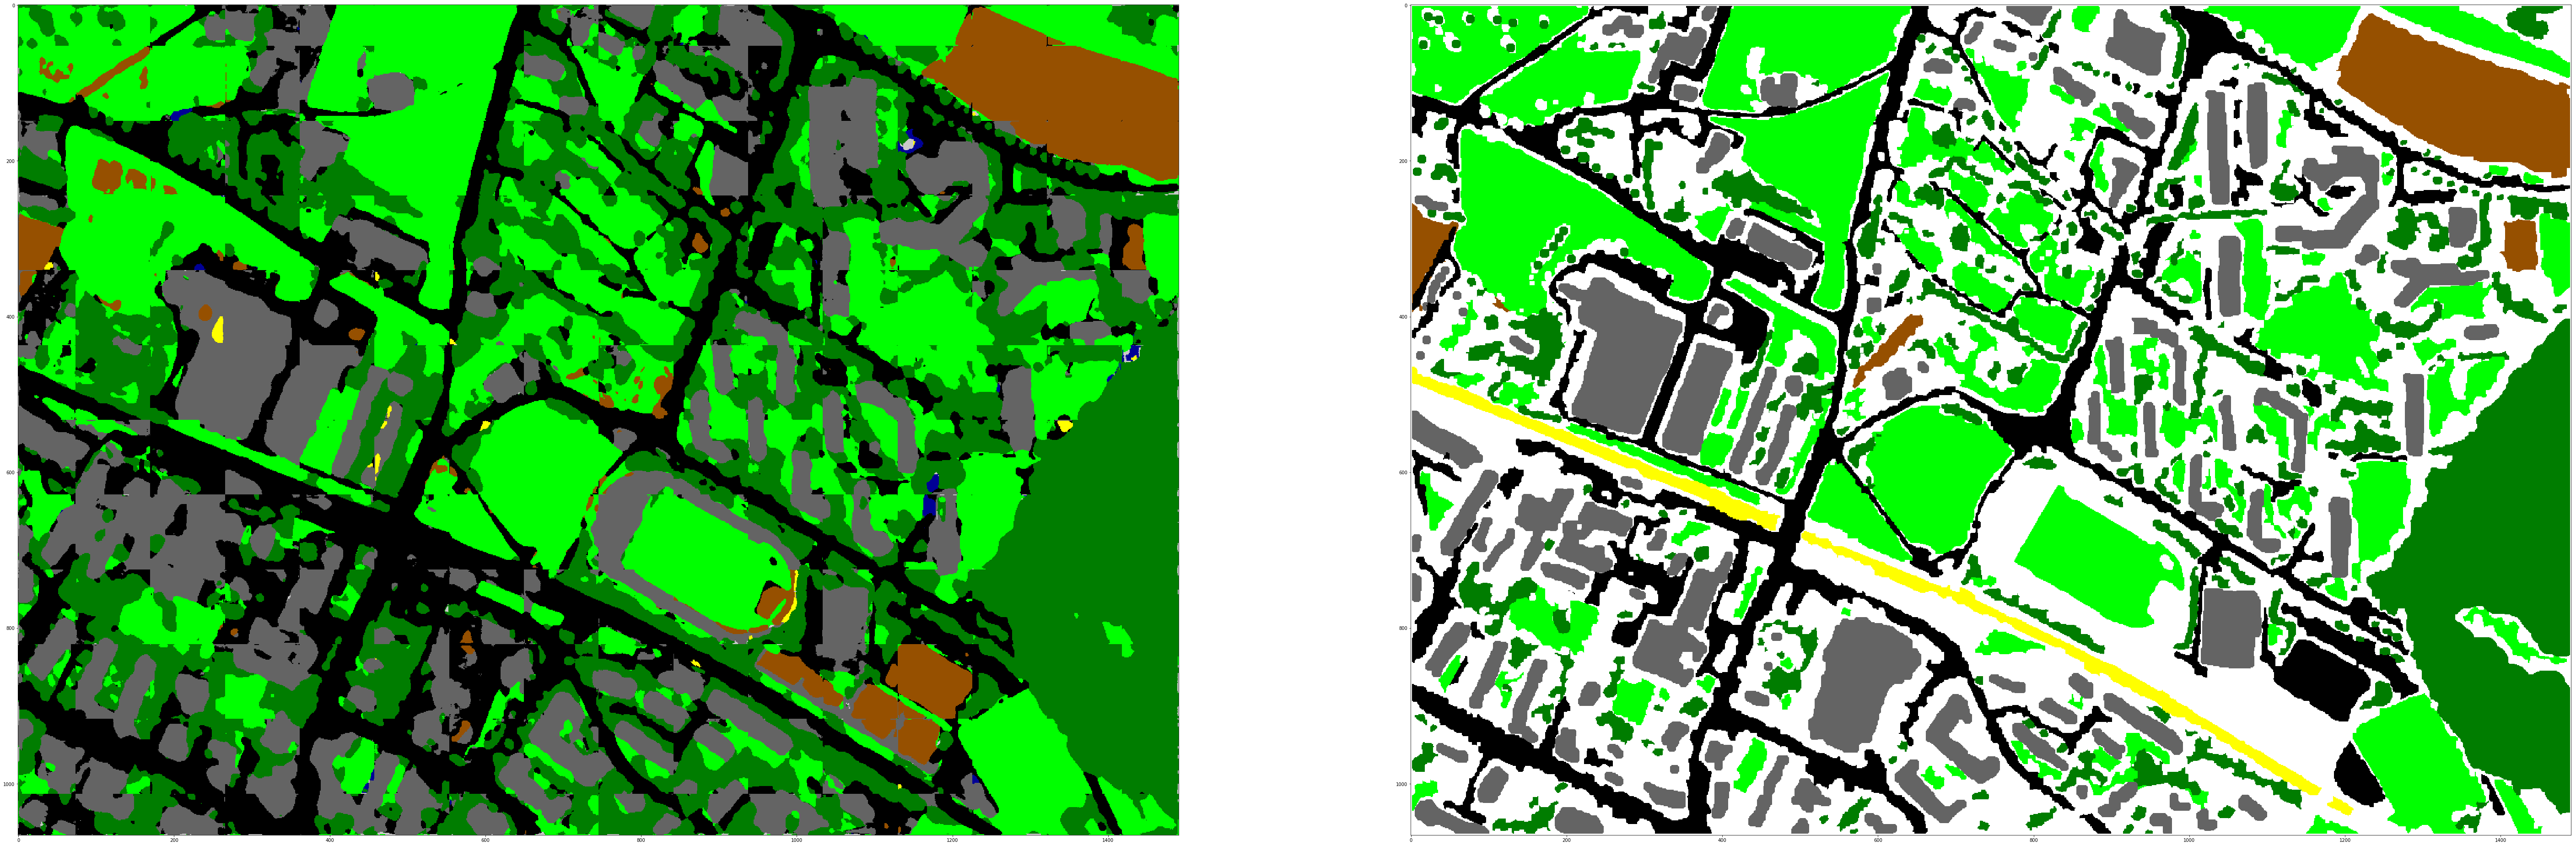

Accuracy is 0.8918677014012487 while leaving Image10
kappa Coef value is 0.8586245347078214
Running for Image 11
27 28 42 42


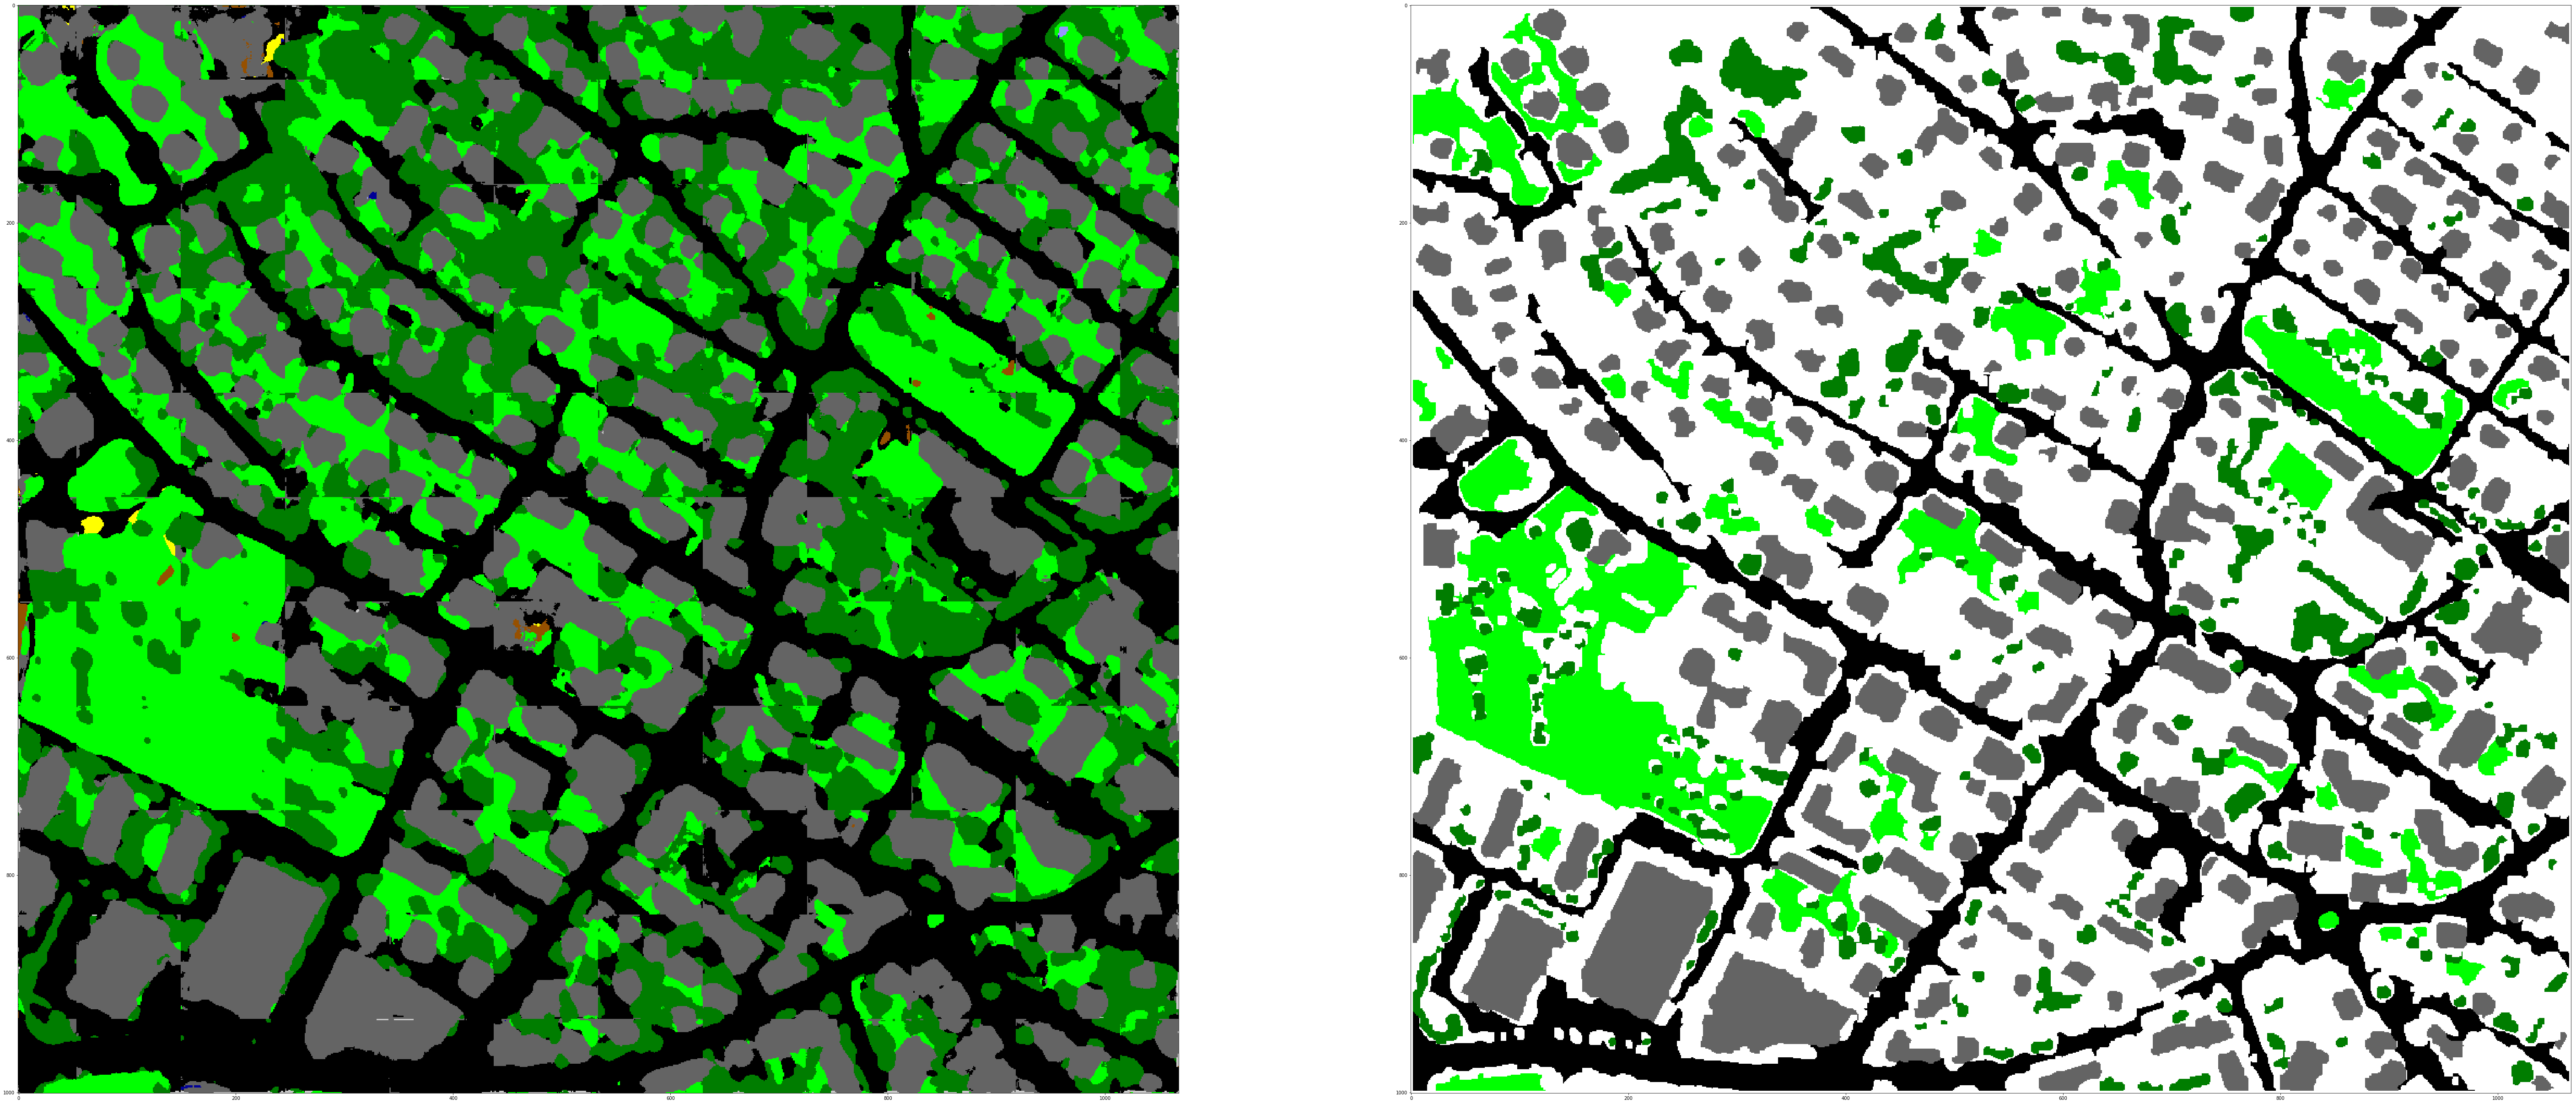

Accuracy is 0.9661417538075282 while leaving Image11
kappa Coef value is 0.9523253012917586
Running for Image 12
26 26 36 36


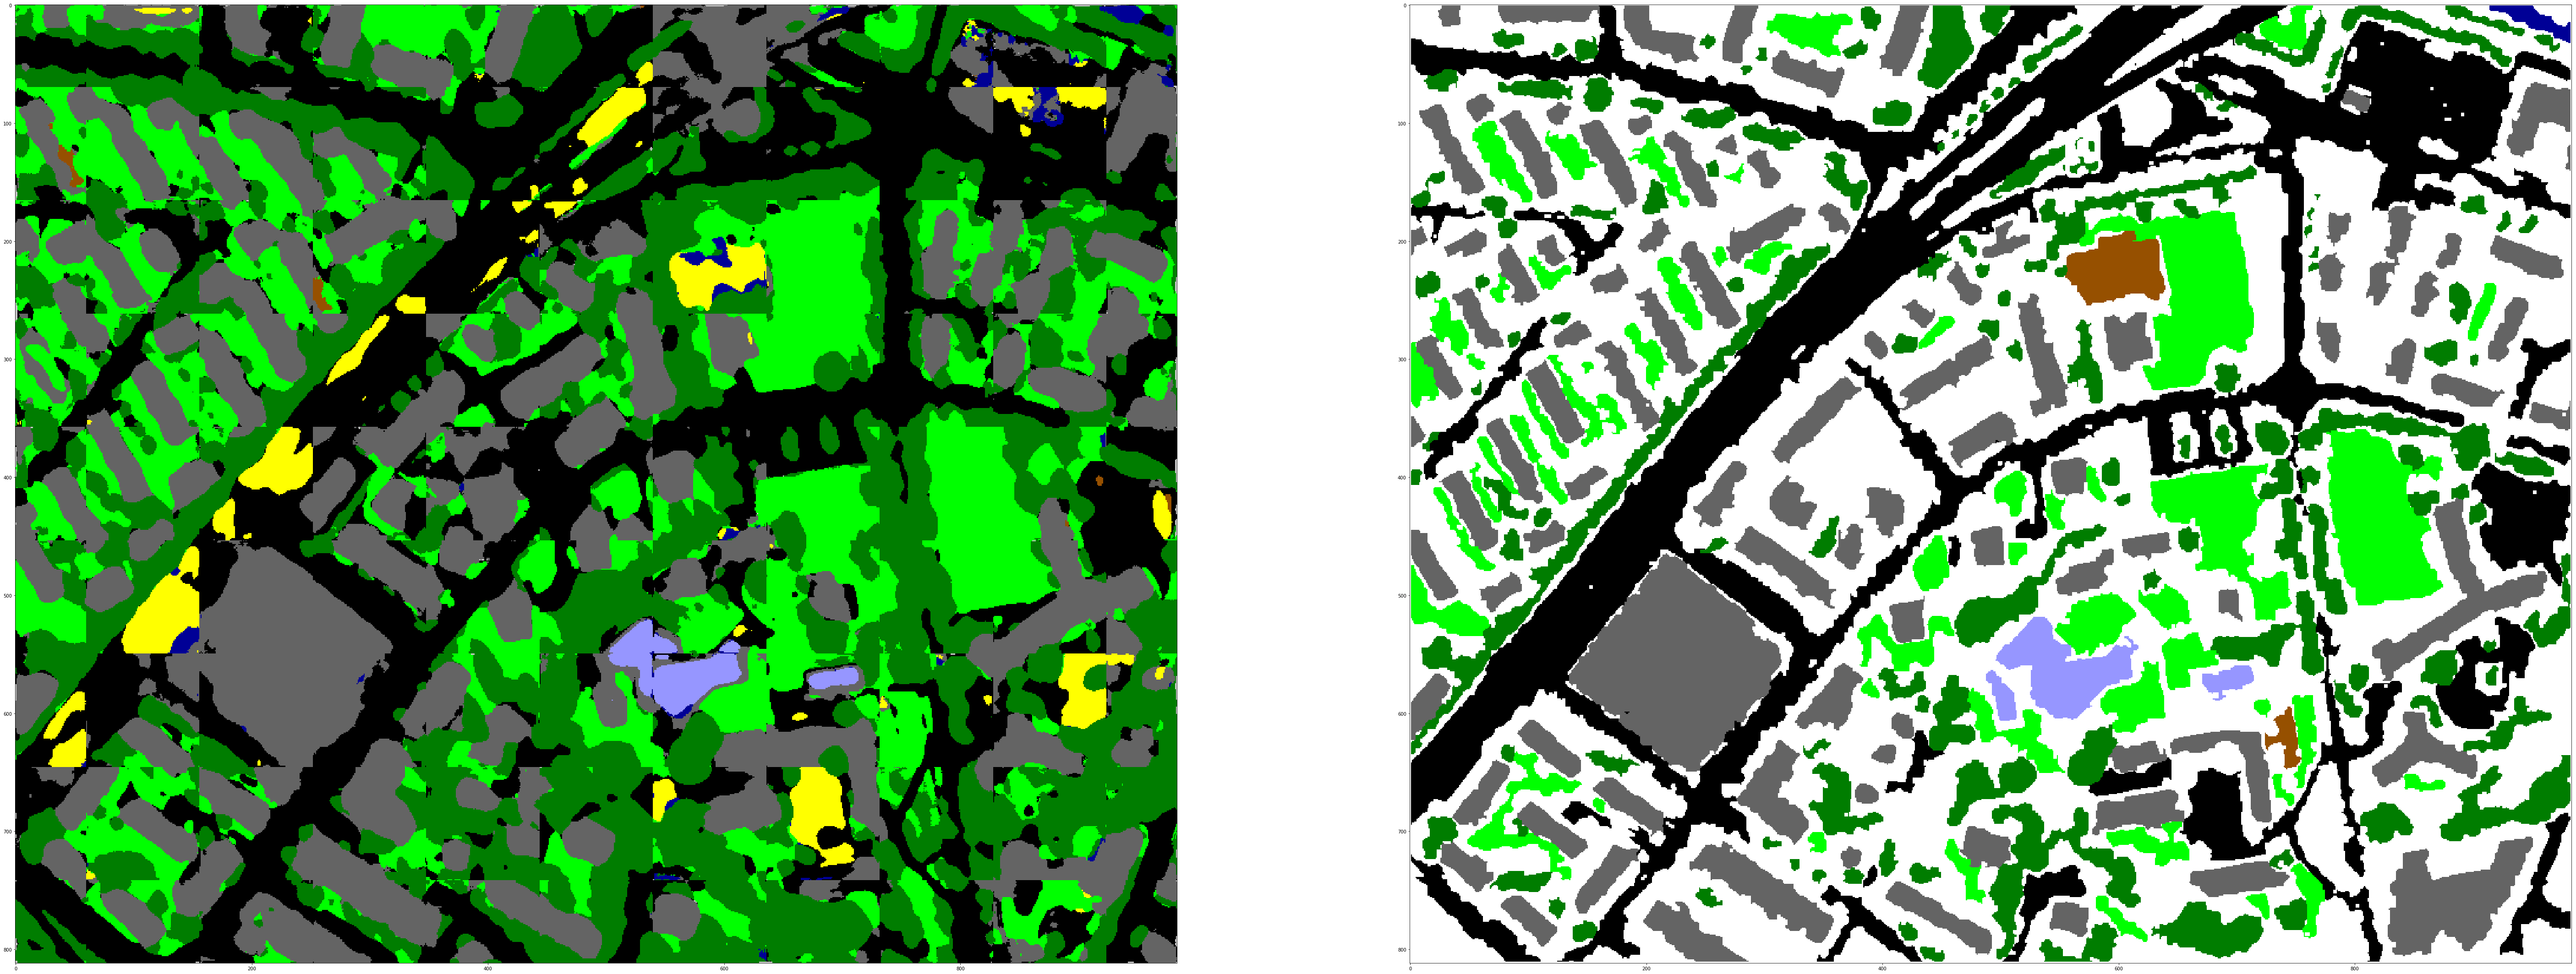

Accuracy is 0.8578603740148301 while leaving Image12
kappa Coef value is 0.811169211841795
Running for Image 13
30 30 6 6


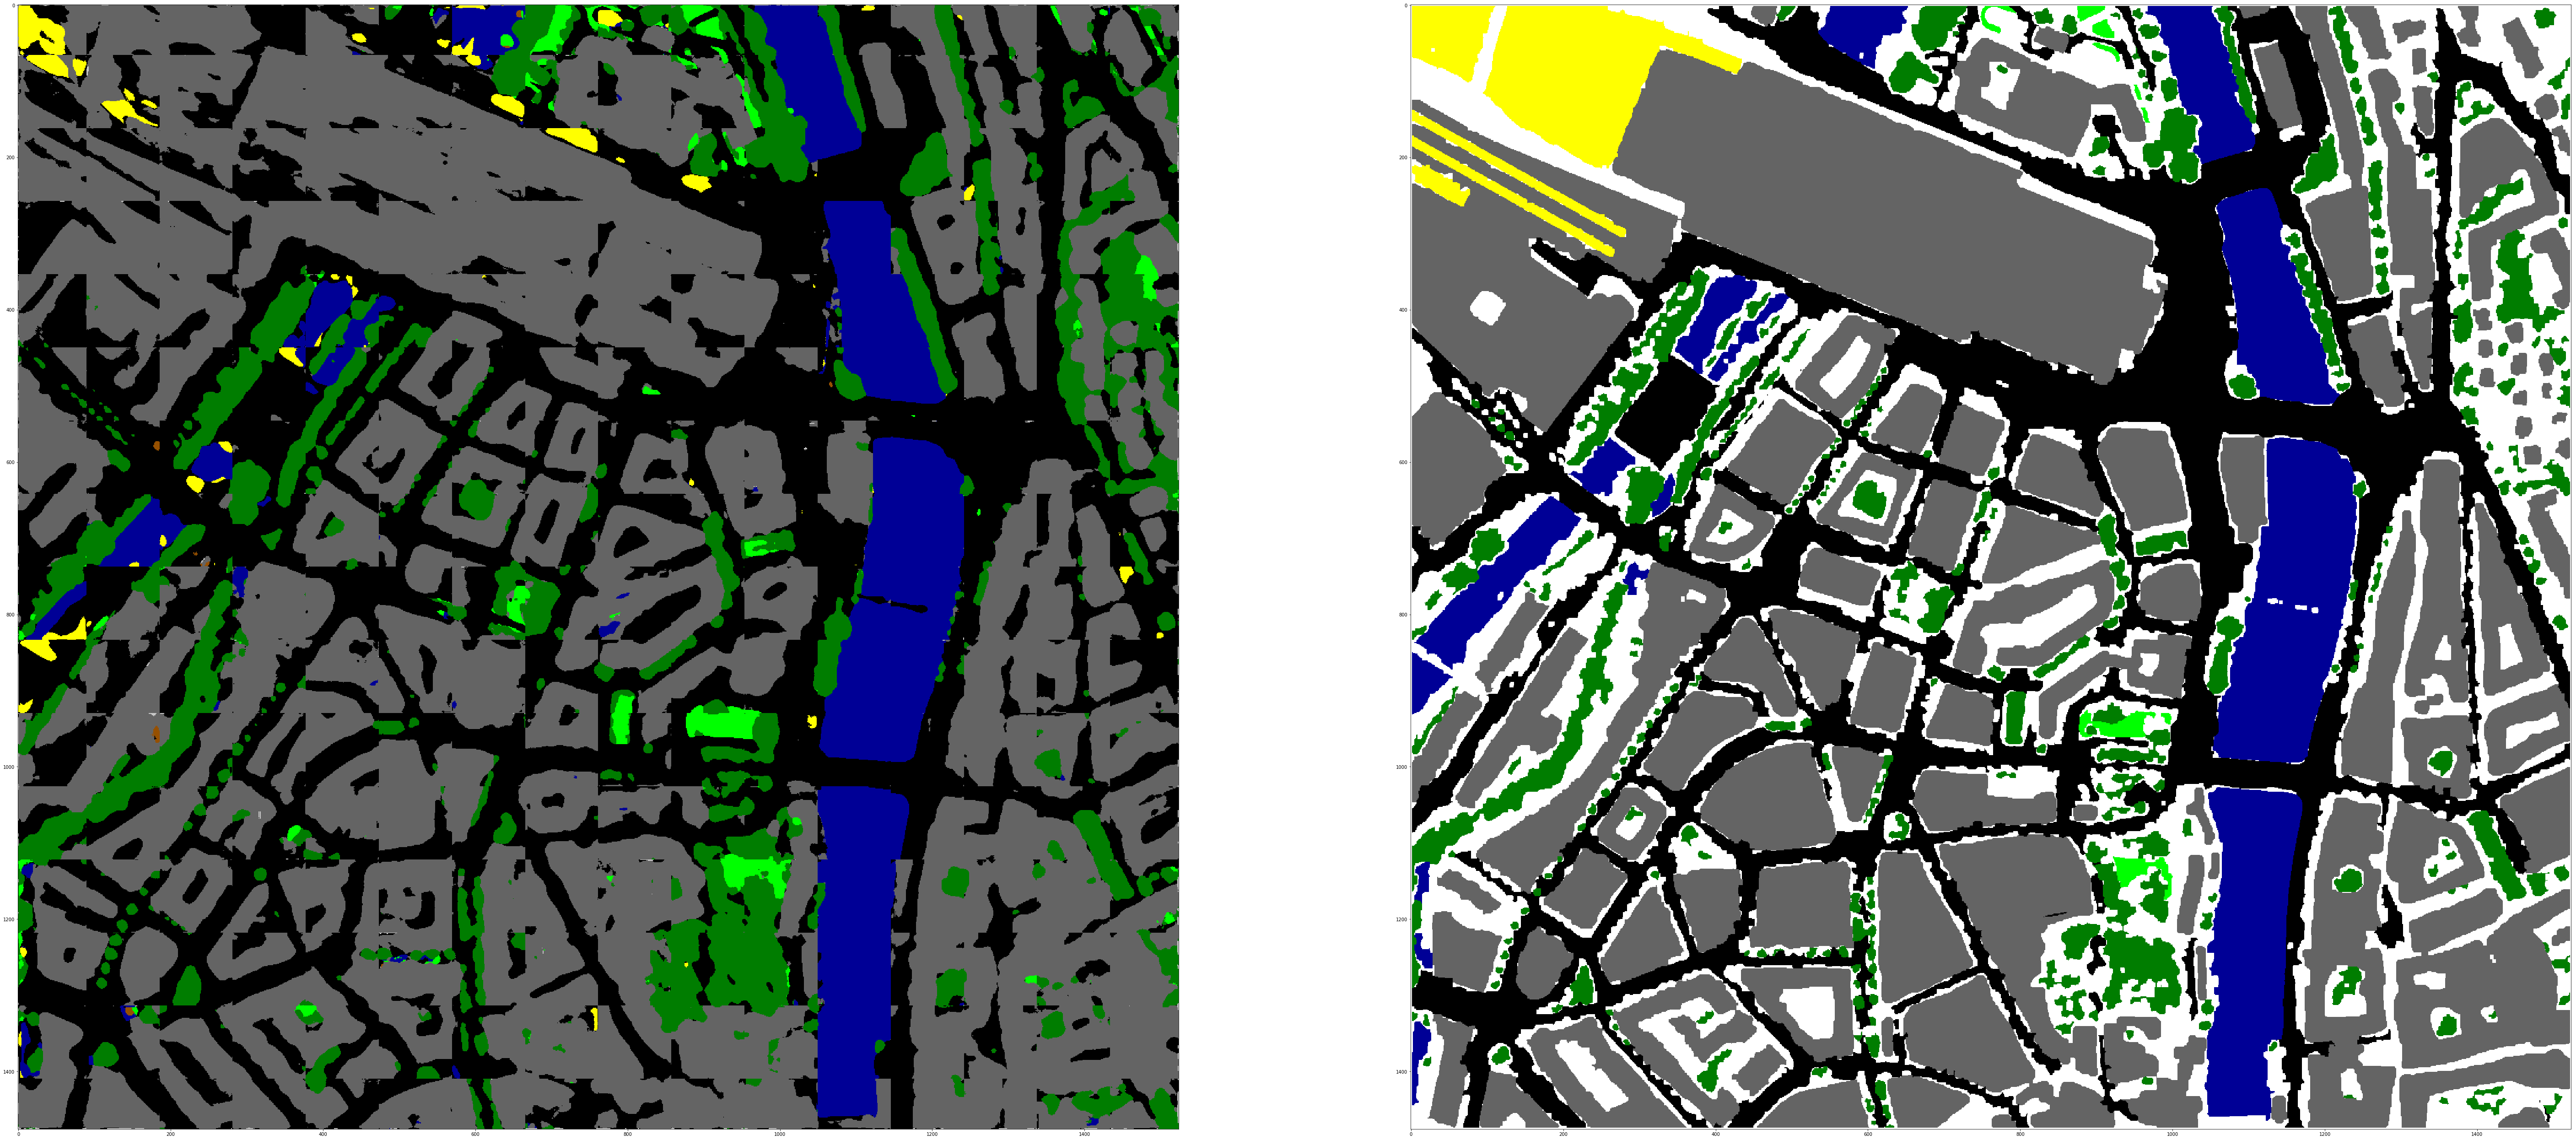

Accuracy is 0.8594058479692286 while leaving Image13
kappa Coef value is 0.7774642241681442
Running for Image 14
25 25 41 41


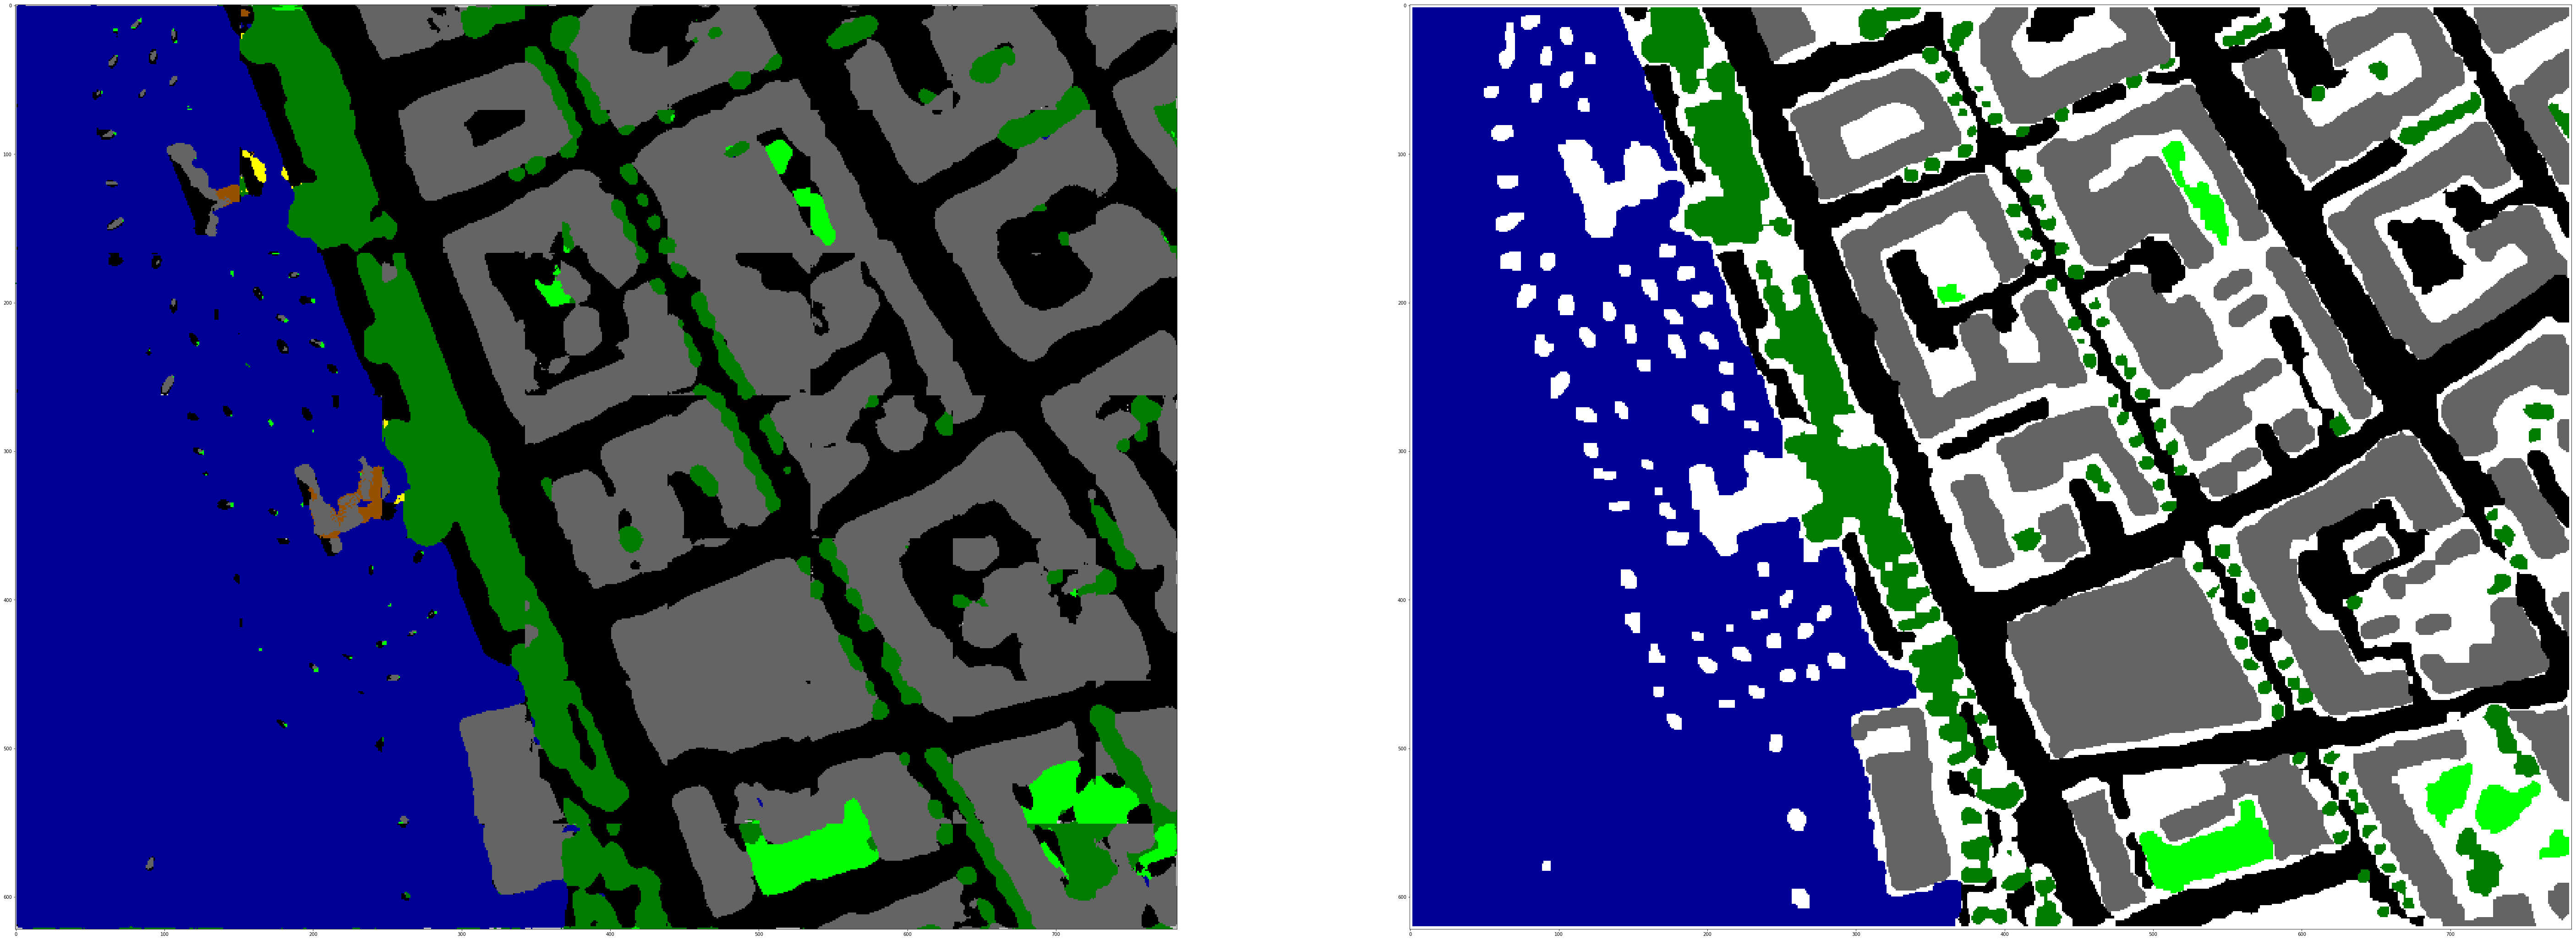

Accuracy is 0.9815419524028408 while leaving Image14
kappa Coef value is 0.9738229386461981


In [16]:
#Function to generate prediction from the leave one out cross validation.
#Example
#cv_weights_v_1.best.hdf5 corresponds to the model trained on all images except 1.tif
#We generate the output of all the models on the images they weren't trained on!
#This has all the Confusion Matrices and the Acuuracies and Kappa Scores
dir_name = "train_x/"##Directory of the Train Images

acc_arr=[]
cf_arr=[]
kapa_coef_arr=[]
for img_id in range(1,15):
        img_path = dir_name+str(img_id)+".tif"
        
        print("Running for Image "+str(img_id))

        
        
        
        filepath= 'cv_weights/cv_weights_v_'+str(img_id)+'.best.hdf5' #Path for the CV weights
        
        
        img = tiff.imread(img_path)
        im = np.copy(img)
        patch_size=96
        image=im[:,:,:]
        image=np.dot(image[...,:],[0.25,0.25,0.25,0.25])
        edge_sobel = sobel(image)
        edge_sobel = np.expand_dims(np.where(edge_sobel>80,4096,0),axis=2)
        old_size = im.shape[:2] # old_size is in (height, width) format
        delta_w = patch_size * (old_size[1]//patch_size) + patch_size  - old_size[1]
        delta_h = patch_size * (old_size[0]//patch_size)+ patch_size - old_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        color = [0,0,0]
        first_three_channels = cv2.copyMakeBorder(im[:,:,:3], top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
        color = [0]
        nir_channel = np.expand_dims(cv2.copyMakeBorder(im[:,:,3], top, bottom, left, right, cv2.BORDER_CONSTANT,value=color),axis=2)
        edge_channel = np.expand_dims(cv2.copyMakeBorder(edge_sobel, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color),axis=2)
        new_im = np.concatenate((first_three_channels,nir_channel,edge_channel),axis=2)
        
        img2 = create_mapping(tiff.imread("train_gt/"+str(img_id)+".tif")) #Path for the ground Truth
        
        print (top,bottom,left,right)
        if img.shape[0]%patch_size!=0 and img.shape[1]%patch_size!=0:
            img1 = generate_whole_mask(new_im,filepath)[ top:-bottom, left:- right]
        
        elif img.shape[0]%patch_size!=0 and img.shape[1]%patch_size==0:
            img1 = generate_whole_mask(new_im,filepath)[ top:-bottom, : ]
            
        
        elif img.shape[0]%patch_size==0 and img.shape[1]%patch_size!=0:
            img1 = generate_whole_mask(new_im,filepath)[ :, left:- right ]
        
        #print (img1.shape,img2.shape)
        
        
        #print (img2.shape,img1.shape)
        #print (img2[0],img1[0])
        

        #Testing







        %matplotlib inline
        gen = inverse_map(img1)
        gen = gen
        #print (gen.shape)
        
        truth = inverse_map(img2)
        #print(truth.shape)
        
        
        plt.close('all')
        plt.figure(figsize=(100,100))
        plt.subplot(1,2,1)
        plt.imshow(gen)
        plt.subplot(1,2,2)
        plt.imshow(truth)
        plt.show()

        cf = confusion_matrix(img2.flatten(),img1.flatten(),labels=[0,1,2,3,4,5,7,9])
        
        kappa_score = sklearn.metrics.cohen_kappa_score(img2.flatten(), img1.flatten(), labels=[0,1,2,3,4,5,7,9])
        
        acc_arr.append(np.trace(cf)/np.sum(cf))
        cf_arr.append(cf)
        kapa_coef_arr.append(kappa_score)
        

    
        print ("Accuracy is "+str(np.trace(cf)/np.sum(cf))+" while leaving Image"+str(img_id))
        print ("kappa Coef value is "+str(kappa_score))
    
    
        





    
    
    
    
    

In [17]:
#Mean Accuracy
np.mean(acc_arr)

0.932383917231996

In [20]:
#Sum of Confusion Matrices
np.sum(cf_arr,axis=0)

array([[2492251,   19370,   32107,   12642,  169020,    4781,      11,
          27776],
       [   6256,  146032,    1293,    9716,    2862,     734,       0,
           2374],
       [  18430,      41, 1477457,   36996,    9066,     279,       0,
            416],
       [   7326,    5418,   46579, 1184478,    4700,      79,       1,
             59],
       [ 240728,    6406,   14410,   10277, 3692092,    1100,      52,
           3915],
       [  17156,      14,    1582,     126,    7084, 1008057,       0,
           3840],
       [    968,       0,     110,     156,    2255,     345,   23593,
              0],
       [  67187,      26,    1822,     295,   52289,     455,       0,
          59506]])

In [21]:
#Mean Kappa Coefficient
np.mean(kapa_coef_arr)

0.9028404562767989